In [16]:
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import collections 
import torch.optim as optim
# from google.colab import drive
# drive.mount('/content/drive') #계정을 연동해야만 내가 만든 py에 접근할 수 있다.
# save_model_path = f"/content/drive/MyDrive/Colab Notebooks/uav.pt"
# save_model_path2 = f"/content/drive/MyDrive/Colab Notebooks/uav_v_net.pt"
save_model_path = f"./uav.pt"
save_model_path2 = f"./uav_v_net.pt"
"""
drone이 user가 있는 곳으 향하는 실험
drone의 시작 지점은 (20,20,200)으로 고정
user는 [rd.randint(150,180),rd.randint(150,180),0] 사이에서 생성 K user

<implementation>
experience replay 
target network
OU noise (Ornstein Uhlenbeck Noise)
<not implementation>
soft target update : 지수 이동 평균과 같은 방법으로 target network update
"""

'\ndrone이 user가 있는 곳으 향하는 실험\ndrone의 시작 지점은 (20,20,200)으로 고정\nuser는 [rd.randint(150,180),rd.randint(150,180),0] 사이에서 생성 K user\n\n<implementation>\nexperience replay \ntarget network\nOU noise (Ornstein Uhlenbeck Noise)\n<not implementation>\nsoft target update : 지수 이동 평균과 같은 방법으로 target network update\n'

In [38]:
#hyperparameters 
MINI_batch = 64
buffer_size = 200000
lr = 0.00025

In [39]:
import random as rd
class env_uav():
    def __init__(self):
        self.q = [[20.,20.,200.]] 
        self.V = 6
        self.L = 3 
        self.K = 5 
        self.T = 60
        self.N = 60
        self.user = []
        self.done = False
        self.t = self.L 
        self.state = []
  
    def user_set(self):
    #user random location    
        for k in range(self.K):
            self.user.append([rd.randint(150,180),rd.randint(150,180),0]) # 5 x 3(x,y,z)
        return self.user

    def cal_rate(self,t): #reward 구할 때
        sum = 0   # time step t에서의 sum rate를 return 즉, 이게 수신 강도이자 reward
        for i in range(self.K):#np.log2
              sum += np.log2(1+1/np.sqrt(np.power(self.q[t][0]-self.user[i][0],2)+np.power(self.q[t][1]-self.user[i][1],2)+np.power(self.q[t][2]-self.user[i][2],2)))
        return sum # 1+를 뺼까
  
    def state_rate(self,t): #state 구할 때
        sum = 0   # time step t에서의 sum rate를 return 즉, 이게 수신 강도이자 reward
        for i in range(self.K):#np.log2
              sum += np.log2(1+1/np.sqrt(np.power(self.q[t][0]-self.user[i][0],2)+np.power(self.q[t][1]-self.user[i][1],2)+np.power(self.q[t][2]-self.user[i][2],2)))
        return sum*1000 # 1+를 뺼까 log를 다시 씌울까


    def q_location(self,a,t): #t+1의 observation  
        #v, seta, low => dtype = tensor
        v , seta , low = a
        v = v.detach().numpy()*self.V; seta = seta.detach().numpy()*180; low = low.detach().numpy()*360

        self.q.append([self.q[t][0] + np.sin(seta*np.pi/180)*np.cos(low*np.pi/180)*v\
                       ,self.q[t][1] + np.sin(low*np.pi/180)*np.sin(seta*np.pi/180)*v,\
                       self.q[t][2] + np.cos(seta*np.pi/180)*v])

    def init_state(self):
        s_0 = self.state_rate(0) # q0에서의 e
        state = []
        for i in range(self.L):
            init_action = torch.tensor([torch.rand(1),torch.rand(1),torch.rand(1)],dtype = torch.float)
            self.q_location(init_action,i) # action받고 행동
            s_1 = self.state_rate(i+1)
            delta = (s_1 - s_0) # state가 너무 작아서 
            state.append(delta)
            s_0 = s_1

        return state
    def reset(self): # q, user,done initialize
        self.user = []
        self.q = [[20.,20.,200.]]
        user = self.user_set()
        self.done = False
        return user

    def current_uav(self): # 현재 uav 위치
        return self.q

    def step(self,a,s,t) : #action받으면 reward와 transition, done return 
        #a는 tensor
        _,delta_2,delta_3 = s
        state = []

        s_0 = self.state_rate(t)  #t에서의 rate
        self.q_location(a,t)  # t+1에서의 위치
        s_1 = self.state_rate(t+1) # t+1에서의 rate
        delta_1 = s_1 - s_0
        delta_1 = delta_1 
        delta_2 = delta_2 
        delta_3 = delta_3 

        state.append(delta_2)
        state.append(delta_3)
        state.append(delta_1)

        r = self.cal_rate(t)

        self.t += 1 #실제로 움직인다 -> time step이 증가 => T가 되면 종료
        if self.t >= self.T:
            self.done = True
        return state, r, self.done # list(3,) , numpy, bool

In [40]:
class VN(nn.Module):
      def __init__(self):
        super().__init__()
        self.fc_1 = nn.Linear(6,256)
        self.fc_2 = nn.Linear(256,256)
        self.fc_3 = nn.Linear(256,256)
        #self.fc_4 = nn.Linear(256,256)
        #self.fc_5 = nn.Linear(256,256)
        self.fc_6 = nn.Linear(256,1)
        self.optimizer = optim.Adam(self.parameters(),lr = lr)
      def forward(self,x):
        x = F.relu(self.fc_1(x))
        x = F.relu(self.fc_2(x))
        x = F.relu(self.fc_3(x))
        #x = F.relu(self.fc_4(x))
        #x = F.relu(self.fc_5(x))
        x = self.fc_6(x) 
        return x

class PN(nn.Module):
    def __init__(self):
        super().__init__()
        self.fc1 = nn.Linear(3,256)
        self.fc2 = nn.Linear(256,256)
        self.fc3 = nn.Linear(256,256)
        #self.fc4 = nn.Linear(256,256)
        #self.fc5 = nn.Linear(256,256)
        self.fc6 = nn.Linear(256,3)

        self.buffer = collections.deque(maxlen = buffer_size)
        self.optimizer = optim.Adam(self.parameters(),lr = lr)

    def forward(self,x):
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = F.relu(self.fc3(x))
        #out4 = F.relu(self.fc4(x))
        #out5 = F.relu(self.fc5(x))
        x = F.sigmoid(self.fc6(x)) 
        return x

    def put_data(self,transition):   
        self.buffer.append(transition)

    def sampling(self,batch_size):
        mini_batch = rd.sample(self.buffer,batch_size) #buffer에서 batch_size만큼 random하게 sampling
        #batch_size x 4
        #list, array, list, numpy, bool
        s_list , a_list , r_list , s_prime_list , done_list = [], [] ,[] ,[] ,[] 

        for transition in mini_batch:
            s, a, r, s_prime, done = transition

            s_list.append(s)
            a_list.append(a)
            r_list.append([r])
            s_prime_list.append(s_prime)
            done_list.append([done])

        return torch.tensor(s_list,dtype=torch.float), torch.tensor(a_list,dtype = torch.float),\
        torch.tensor(r_list,dtype = torch.float),torch.tensor(s_prime_list,dtype = torch.float),\
         torch.tensor(done_list,dtype = torch.float)

    def size(self):
        return len(self.buffer)

    def train(self,V_net,V_target,P_target):
        for i in range(10):
            s, a, r, s_prime, done = self.sampling(MINI_batch)



            a_prime = P_target.forward(s_prime) # a'
            s_a = torch.hstack((s,a)) # Q_value network의 input
            s_prime_a = torch.hstack((s_prime,a_prime))

            value_s_prime = V_target(s_prime_a) # tensor
            td_target = r + value_s_prime*done #
            value_s = V_net(s_a) # batch x 1  tensor

            V_loss = F.smooth_l1_loss(value_s,td_target.detach())
            V_net.optimizer.zero_grad()
            V_loss.backward()
            V_net.optimizer.step()

            a_P = self.forward(s)
            s_a2 = torch.hstack((s,a_P))
            P_loss = -torch.mean(V_net(s_a2))
            self.optimizer.zero_grad()
            P_loss.backward()
            self.optimizer.step()

        return V_loss.item(), P_loss.item()

In [41]:
env = env_uav() #### replay buffer size 늘려보기
policy = PN()
#policy.load_state_dict(torch.load(save_model_path)) # training된 parameter load 
policy_target = PN() 

value = VN()
#value.load_state_dict(torch.load(save_model_path2))
value_target = VN()

policy_target.load_state_dict(policy.state_dict())
value_target.load_state_dict(value.state_dict())


M = 150000
avgv_loss =0
avgp_loss =0
sum_rate =0 
avg_t = 20#100
V_loss = 0
P_loss = 0
best_epi_rate = 0

for m in range(M):
  #user generate, p, done 초기화
  user = env.reset()
  #1 ~ L 까지 random action =======================================
  s = env.init_state() #(3,)
  done = False

  for t in range(3,60):
    action =policy(torch.tensor(s).float()) 
    v, seta, low = torch.randn(1), torch.rand(1),torch.rand(1)
    #print(s)
    #print(action)
    a = action
    a.data[0] += v[0]; a.data[1] += seta[0]; a.data[2] += low[0];
    s_prime , reward, _ = env.step(a,s,t)  
    
    # list, numpy, bool
    done_num = 1.0
    if t == 60 : # 사실 for문이 다 돌면 끝난다.
      done_num =0.0
      done = True

    a = action.detach().numpy()
    policy.put_data((s,a,reward, s_prime,done_num)) # buffer에 저장
    s = s_prime
    
    if done == True:
      break
  if policy.size() > 10000:
    V_loss,P_loss = policy.train(value,value_target,policy_target)
  avgv_loss += V_loss
  avgp_loss += P_loss
  epi_rate = 0 # 종료 조건;

  for i in range(60):
     sum_rate += env.cal_rate(i)
     epi_rate += env.cal_rate(i)
  
  if epi_rate >= best_epi_rate :
    torch.save(policy.state_dict(),save_model_path)
    torch.save(value.state_dict(),save_model_path2)
    print("\nepi_rate",epi_rate)
    best_epi_rate = epi_rate
    
  if m%avg_t == 0 and m!=0 :
    #print(reward)
    policy_target.load_state_dict(policy.state_dict())
    value_target.load_state_dict(value.state_dict())
    print("episode : {}, buffer_size : {}, v_loss : {:.4f}, p_loss : {:.4f}, avg_sum_rate : {:.4f} , epi_rate = {:.4f}"\
          .format(m,policy.size(),avgv_loss/avg_t,avgp_loss/avg_t,sum_rate/avg_t,epi_rate))
    avgv_loss = 0
    avgp_loss = 0
    sum_rate = 0 
                                  # deep한 정도                                                   
                                  


epi_rate 1.8966711469378914

epi_rate 1.9079791889875897
episode : 20, buffer_size : 1197, v_loss : 0.0000, p_loss : 0.0000, avg_sum_rate : 1.8188 , epi_rate = 1.6025
episode : 40, buffer_size : 2337, v_loss : 0.0000, p_loss : 0.0000, avg_sum_rate : 1.7055 , epi_rate = 1.7002

epi_rate 1.9127546242741436
episode : 60, buffer_size : 3477, v_loss : 0.0000, p_loss : 0.0000, avg_sum_rate : 1.6714 , epi_rate = 1.7445

epi_rate 2.021386612571759
episode : 80, buffer_size : 4617, v_loss : 0.0000, p_loss : 0.0000, avg_sum_rate : 1.7223 , epi_rate = 1.5325
episode : 100, buffer_size : 5757, v_loss : 0.0000, p_loss : 0.0000, avg_sum_rate : 1.6944 , epi_rate = 1.7436

epi_rate 2.053680950057955
episode : 120, buffer_size : 6897, v_loss : 0.0000, p_loss : 0.0000, avg_sum_rate : 1.6869 , epi_rate = 1.5997
episode : 140, buffer_size : 8037, v_loss : 0.0000, p_loss : 0.0000, avg_sum_rate : 1.6817 , epi_rate = 1.6165
episode : 160, buffer_size : 9177, v_loss : 0.0000, p_loss : 0.0000, avg_sum_rate : 

episode : 1440, buffer_size : 82137, v_loss : 0.0000, p_loss : -2.0266, avg_sum_rate : 1.6598 , epi_rate = 1.8510
episode : 1460, buffer_size : 83277, v_loss : 0.0000, p_loss : -2.0612, avg_sum_rate : 1.6670 , epi_rate = 1.6673
episode : 1480, buffer_size : 84417, v_loss : 0.0000, p_loss : -2.0968, avg_sum_rate : 1.6773 , epi_rate = 1.7100
episode : 1500, buffer_size : 85557, v_loss : 0.0000, p_loss : -2.1335, avg_sum_rate : 1.7011 , epi_rate = 1.7642
episode : 1520, buffer_size : 86697, v_loss : 0.0000, p_loss : -2.1649, avg_sum_rate : 1.6630 , epi_rate = 1.7283
episode : 1540, buffer_size : 87837, v_loss : 0.0000, p_loss : -2.1972, avg_sum_rate : 1.7099 , epi_rate = 1.6323
episode : 1560, buffer_size : 88977, v_loss : 0.0000, p_loss : -2.2284, avg_sum_rate : 1.6463 , epi_rate = 1.7265
episode : 1580, buffer_size : 90117, v_loss : 0.0000, p_loss : -2.2658, avg_sum_rate : 1.6266 , epi_rate = 1.5429
episode : 1600, buffer_size : 91257, v_loss : 0.0000, p_loss : -2.3041, avg_sum_rate : 1

episode : 2880, buffer_size : 164217, v_loss : 0.0001, p_loss : -4.9686, avg_sum_rate : 1.6312 , epi_rate = 1.5407
episode : 2900, buffer_size : 165357, v_loss : 0.0001, p_loss : -5.0174, avg_sum_rate : 1.6434 , epi_rate = 1.6838
episode : 2920, buffer_size : 166497, v_loss : 0.0001, p_loss : -5.0554, avg_sum_rate : 1.6494 , epi_rate = 1.6120
episode : 2940, buffer_size : 167637, v_loss : 0.0001, p_loss : -5.1070, avg_sum_rate : 1.6463 , epi_rate = 1.5030
episode : 2960, buffer_size : 168777, v_loss : 0.0001, p_loss : -5.1520, avg_sum_rate : 1.7072 , epi_rate = 1.6841
episode : 2980, buffer_size : 169917, v_loss : 0.0001, p_loss : -5.2065, avg_sum_rate : 1.6434 , epi_rate = 1.5197
episode : 3000, buffer_size : 171057, v_loss : 0.0002, p_loss : -5.2506, avg_sum_rate : 1.6825 , epi_rate = 1.7371
episode : 3020, buffer_size : 172197, v_loss : 0.0001, p_loss : -5.3104, avg_sum_rate : 1.6815 , epi_rate = 1.6442
episode : 3040, buffer_size : 173337, v_loss : 0.0001, p_loss : -5.3503, avg_sum

episode : 4320, buffer_size : 200000, v_loss : 0.0002, p_loss : -8.6399, avg_sum_rate : 1.6701 , epi_rate = 1.6615
episode : 4340, buffer_size : 200000, v_loss : 0.0002, p_loss : -8.6888, avg_sum_rate : 1.6472 , epi_rate = 1.5298
episode : 4360, buffer_size : 200000, v_loss : 0.0002, p_loss : -8.7623, avg_sum_rate : 1.6170 , epi_rate = 1.4441
episode : 4380, buffer_size : 200000, v_loss : 0.0004, p_loss : -8.7996, avg_sum_rate : 1.6667 , epi_rate = 1.7466
episode : 4400, buffer_size : 200000, v_loss : 0.0003, p_loss : -8.8468, avg_sum_rate : 1.6317 , epi_rate = 1.5739
episode : 4420, buffer_size : 200000, v_loss : 0.0002, p_loss : -8.8889, avg_sum_rate : 1.7143 , epi_rate = 1.6099
episode : 4440, buffer_size : 200000, v_loss : 0.0002, p_loss : -8.9520, avg_sum_rate : 1.6609 , epi_rate = 1.6583
episode : 4460, buffer_size : 200000, v_loss : 0.0002, p_loss : -9.0223, avg_sum_rate : 1.6689 , epi_rate = 1.7968
episode : 4480, buffer_size : 200000, v_loss : 0.0001, p_loss : -9.0630, avg_sum

episode : 5740, buffer_size : 200000, v_loss : 0.0001, p_loss : -12.1469, avg_sum_rate : 1.6802 , epi_rate = 1.6729
episode : 5760, buffer_size : 200000, v_loss : 0.0002, p_loss : -12.1795, avg_sum_rate : 1.7464 , epi_rate = 1.7961
episode : 5780, buffer_size : 200000, v_loss : 0.0001, p_loss : -12.2353, avg_sum_rate : 1.6722 , epi_rate = 1.7407
episode : 5800, buffer_size : 200000, v_loss : 0.0001, p_loss : -12.3012, avg_sum_rate : 1.6257 , epi_rate = 1.5934
episode : 5820, buffer_size : 200000, v_loss : 0.0001, p_loss : -12.3442, avg_sum_rate : 1.6856 , epi_rate = 1.6266
episode : 5840, buffer_size : 200000, v_loss : 0.0002, p_loss : -12.3844, avg_sum_rate : 1.6656 , epi_rate = 1.6274
episode : 5860, buffer_size : 200000, v_loss : 0.0001, p_loss : -12.4263, avg_sum_rate : 1.6585 , epi_rate = 1.6318
episode : 5880, buffer_size : 200000, v_loss : 0.0002, p_loss : -12.4707, avg_sum_rate : 1.6702 , epi_rate = 1.9880
episode : 5900, buffer_size : 200000, v_loss : 0.0002, p_loss : -12.5174

episode : 7160, buffer_size : 200000, v_loss : 0.0002, p_loss : -15.6194, avg_sum_rate : 1.6898 , epi_rate = 1.5236
episode : 7180, buffer_size : 200000, v_loss : 0.0002, p_loss : -15.6471, avg_sum_rate : 1.6224 , epi_rate = 1.7286
episode : 7200, buffer_size : 200000, v_loss : 0.0001, p_loss : -15.6873, avg_sum_rate : 1.5977 , epi_rate = 1.7503
episode : 7220, buffer_size : 200000, v_loss : 0.0001, p_loss : -15.7369, avg_sum_rate : 1.6669 , epi_rate = 1.5218
episode : 7240, buffer_size : 200000, v_loss : 0.0001, p_loss : -15.7729, avg_sum_rate : 1.6512 , epi_rate = 1.5855
episode : 7260, buffer_size : 200000, v_loss : 0.0002, p_loss : -15.8378, avg_sum_rate : 1.6217 , epi_rate = 1.6771
episode : 7280, buffer_size : 200000, v_loss : 0.0003, p_loss : -15.8830, avg_sum_rate : 1.7450 , epi_rate = 1.6229
episode : 7300, buffer_size : 200000, v_loss : 0.0001, p_loss : -15.9223, avg_sum_rate : 1.7161 , epi_rate = 1.6372
episode : 7320, buffer_size : 200000, v_loss : 0.0001, p_loss : -15.9661

episode : 8580, buffer_size : 200000, v_loss : 0.0003, p_loss : -19.3179, avg_sum_rate : 1.6695 , epi_rate = 1.6682
episode : 8600, buffer_size : 200000, v_loss : 0.0004, p_loss : -19.3988, avg_sum_rate : 1.6503 , epi_rate = 1.7459
episode : 8620, buffer_size : 200000, v_loss : 0.0003, p_loss : -19.4659, avg_sum_rate : 1.6009 , epi_rate = 1.4578
episode : 8640, buffer_size : 200000, v_loss : 0.0003, p_loss : -19.5365, avg_sum_rate : 1.6325 , epi_rate = 1.7499
episode : 8660, buffer_size : 200000, v_loss : 0.0002, p_loss : -19.6227, avg_sum_rate : 1.7287 , epi_rate = 1.7721
episode : 8680, buffer_size : 200000, v_loss : 0.0002, p_loss : -19.6633, avg_sum_rate : 1.6953 , epi_rate = 1.7871
episode : 8700, buffer_size : 200000, v_loss : 0.0001, p_loss : -19.6963, avg_sum_rate : 1.6269 , epi_rate = 1.5676
episode : 8720, buffer_size : 200000, v_loss : 0.0002, p_loss : -19.7424, avg_sum_rate : 1.6560 , epi_rate = 1.8475
episode : 8740, buffer_size : 200000, v_loss : 0.0003, p_loss : -19.7787

episode : 10000, buffer_size : 200000, v_loss : 0.0001, p_loss : -23.1516, avg_sum_rate : 1.5058 , epi_rate = 1.7548
episode : 10020, buffer_size : 200000, v_loss : 0.0002, p_loss : -23.2050, avg_sum_rate : 1.5821 , epi_rate = 1.3868
episode : 10040, buffer_size : 200000, v_loss : 0.0002, p_loss : -23.2482, avg_sum_rate : 1.5797 , epi_rate = 1.6189
episode : 10060, buffer_size : 200000, v_loss : 0.0002, p_loss : -23.3043, avg_sum_rate : 1.6119 , epi_rate = 1.5129
episode : 10080, buffer_size : 200000, v_loss : 0.0002, p_loss : -23.3559, avg_sum_rate : 1.5736 , epi_rate = 1.7075
episode : 10100, buffer_size : 200000, v_loss : 0.0001, p_loss : -23.4171, avg_sum_rate : 1.5850 , epi_rate = 1.4345
episode : 10120, buffer_size : 200000, v_loss : 0.0002, p_loss : -23.4564, avg_sum_rate : 1.5536 , epi_rate = 1.6468
episode : 10140, buffer_size : 200000, v_loss : 0.0002, p_loss : -23.5029, avg_sum_rate : 1.5780 , epi_rate = 1.7277
episode : 10160, buffer_size : 200000, v_loss : 0.0002, p_loss :

episode : 11420, buffer_size : 200000, v_loss : 0.0002, p_loss : -26.1722, avg_sum_rate : 1.5058 , epi_rate = 1.5652
episode : 11440, buffer_size : 200000, v_loss : 0.0004, p_loss : -26.2139, avg_sum_rate : 1.4979 , epi_rate = 1.6870
episode : 11460, buffer_size : 200000, v_loss : 0.0002, p_loss : -26.2468, avg_sum_rate : 1.5208 , epi_rate = 1.4233
episode : 11480, buffer_size : 200000, v_loss : 0.0002, p_loss : -26.2916, avg_sum_rate : 1.5278 , epi_rate = 1.5923
episode : 11500, buffer_size : 200000, v_loss : 0.0002, p_loss : -26.3284, avg_sum_rate : 1.5801 , epi_rate = 1.7234
episode : 11520, buffer_size : 200000, v_loss : 0.0002, p_loss : -26.3677, avg_sum_rate : 1.5023 , epi_rate = 1.4358
episode : 11540, buffer_size : 200000, v_loss : 0.0001, p_loss : -26.4147, avg_sum_rate : 1.5385 , epi_rate = 1.4543
episode : 11560, buffer_size : 200000, v_loss : 0.0002, p_loss : -26.4712, avg_sum_rate : 1.5512 , epi_rate = 1.3538
episode : 11580, buffer_size : 200000, v_loss : 0.0001, p_loss :

episode : 12820, buffer_size : 200000, v_loss : 0.0001, p_loss : -28.7179, avg_sum_rate : 1.5378 , epi_rate = 1.4022
episode : 12840, buffer_size : 200000, v_loss : 0.0001, p_loss : -28.7435, avg_sum_rate : 1.5692 , epi_rate = 1.6034
episode : 12860, buffer_size : 200000, v_loss : 0.0002, p_loss : -28.7770, avg_sum_rate : 1.5027 , epi_rate = 1.3653
episode : 12880, buffer_size : 200000, v_loss : 0.0002, p_loss : -28.7972, avg_sum_rate : 1.5402 , epi_rate = 1.5205
episode : 12900, buffer_size : 200000, v_loss : 0.0003, p_loss : -28.8520, avg_sum_rate : 1.5233 , epi_rate = 1.7404
episode : 12920, buffer_size : 200000, v_loss : 0.0001, p_loss : -28.8688, avg_sum_rate : 1.5550 , epi_rate = 1.4754
episode : 12940, buffer_size : 200000, v_loss : 0.0001, p_loss : -28.9044, avg_sum_rate : 1.5362 , epi_rate = 1.5168
episode : 12960, buffer_size : 200000, v_loss : 0.0001, p_loss : -28.9383, avg_sum_rate : 1.5210 , epi_rate = 1.5070
episode : 12980, buffer_size : 200000, v_loss : 0.0001, p_loss :

episode : 14240, buffer_size : 200000, v_loss : 0.0001, p_loss : -31.3227, avg_sum_rate : 1.5629 , epi_rate = 1.4207
episode : 14260, buffer_size : 200000, v_loss : 0.0003, p_loss : -31.3682, avg_sum_rate : 1.5632 , epi_rate = 1.5932
episode : 14280, buffer_size : 200000, v_loss : 0.0002, p_loss : -31.3949, avg_sum_rate : 1.4981 , epi_rate = 1.4422
episode : 14300, buffer_size : 200000, v_loss : 0.0002, p_loss : -31.4229, avg_sum_rate : 1.5471 , epi_rate = 1.6039
episode : 14320, buffer_size : 200000, v_loss : 0.0002, p_loss : -31.4469, avg_sum_rate : 1.5039 , epi_rate = 1.4273
episode : 14340, buffer_size : 200000, v_loss : 0.0002, p_loss : -31.4799, avg_sum_rate : 1.4859 , epi_rate = 1.6383
episode : 14360, buffer_size : 200000, v_loss : 0.0002, p_loss : -31.5314, avg_sum_rate : 1.5036 , epi_rate = 1.4508
episode : 14380, buffer_size : 200000, v_loss : 0.0003, p_loss : -31.5897, avg_sum_rate : 1.5080 , epi_rate = 1.5100
episode : 14400, buffer_size : 200000, v_loss : 0.0001, p_loss :

episode : 15660, buffer_size : 200000, v_loss : 0.0002, p_loss : -33.7465, avg_sum_rate : 1.5853 , epi_rate = 1.7921
episode : 15680, buffer_size : 200000, v_loss : 0.0003, p_loss : -33.7846, avg_sum_rate : 1.5122 , epi_rate = 1.5852
episode : 15700, buffer_size : 200000, v_loss : 0.0003, p_loss : -33.8030, avg_sum_rate : 1.5297 , epi_rate = 1.4268
episode : 15720, buffer_size : 200000, v_loss : 0.0002, p_loss : -33.8265, avg_sum_rate : 1.5349 , epi_rate = 1.5882
episode : 15740, buffer_size : 200000, v_loss : 0.0003, p_loss : -33.8747, avg_sum_rate : 1.5325 , epi_rate = 1.6266
episode : 15760, buffer_size : 200000, v_loss : 0.0002, p_loss : -33.9000, avg_sum_rate : 1.5695 , epi_rate = 1.5846
episode : 15780, buffer_size : 200000, v_loss : 0.0002, p_loss : -33.9409, avg_sum_rate : 1.5167 , epi_rate = 1.4539
episode : 15800, buffer_size : 200000, v_loss : 0.0002, p_loss : -33.9926, avg_sum_rate : 1.5390 , epi_rate = 1.9334
episode : 15820, buffer_size : 200000, v_loss : 0.0004, p_loss :

episode : 17080, buffer_size : 200000, v_loss : 0.0002, p_loss : -35.9192, avg_sum_rate : 1.5360 , epi_rate = 1.4348
episode : 17100, buffer_size : 200000, v_loss : 0.0001, p_loss : -35.9582, avg_sum_rate : 1.5542 , epi_rate = 1.5934
episode : 17120, buffer_size : 200000, v_loss : 0.0002, p_loss : -35.9940, avg_sum_rate : 1.5450 , epi_rate = 1.5110
episode : 17140, buffer_size : 200000, v_loss : 0.0001, p_loss : -36.0151, avg_sum_rate : 1.5374 , epi_rate = 1.5390
episode : 17160, buffer_size : 200000, v_loss : 0.0001, p_loss : -36.0316, avg_sum_rate : 1.5258 , epi_rate = 1.5103
episode : 17180, buffer_size : 200000, v_loss : 0.0002, p_loss : -36.0642, avg_sum_rate : 1.5182 , epi_rate = 1.5938
episode : 17200, buffer_size : 200000, v_loss : 0.0003, p_loss : -36.1191, avg_sum_rate : 1.4983 , epi_rate = 1.5164
episode : 17220, buffer_size : 200000, v_loss : 0.0001, p_loss : -36.1583, avg_sum_rate : 1.5278 , epi_rate = 1.5141
episode : 17240, buffer_size : 200000, v_loss : 0.0003, p_loss :

episode : 18500, buffer_size : 200000, v_loss : 0.0002, p_loss : -38.3645, avg_sum_rate : 1.4886 , epi_rate = 1.6756
episode : 18520, buffer_size : 200000, v_loss : 0.0002, p_loss : -38.4088, avg_sum_rate : 1.5297 , epi_rate = 1.5519
episode : 18540, buffer_size : 200000, v_loss : 0.0003, p_loss : -38.4697, avg_sum_rate : 1.5163 , epi_rate = 1.6028
episode : 18560, buffer_size : 200000, v_loss : 0.0003, p_loss : -38.4813, avg_sum_rate : 1.5591 , epi_rate = 1.5953
episode : 18580, buffer_size : 200000, v_loss : 0.0003, p_loss : -38.4904, avg_sum_rate : 1.5542 , epi_rate = 1.6137
episode : 18600, buffer_size : 200000, v_loss : 0.0002, p_loss : -38.5272, avg_sum_rate : 1.5304 , epi_rate = 1.4662
episode : 18620, buffer_size : 200000, v_loss : 0.0002, p_loss : -38.5646, avg_sum_rate : 1.5199 , epi_rate = 1.5482
episode : 18640, buffer_size : 200000, v_loss : 0.0004, p_loss : -38.5946, avg_sum_rate : 1.5217 , epi_rate = 1.5974
episode : 18660, buffer_size : 200000, v_loss : 0.0003, p_loss :

episode : 19920, buffer_size : 200000, v_loss : 0.0002, p_loss : -40.7235, avg_sum_rate : 1.5402 , epi_rate = 1.7667
episode : 19940, buffer_size : 200000, v_loss : 0.0003, p_loss : -40.7732, avg_sum_rate : 1.5033 , epi_rate = 1.6179
episode : 19960, buffer_size : 200000, v_loss : 0.0001, p_loss : -40.8120, avg_sum_rate : 1.4926 , epi_rate = 1.3544
episode : 19980, buffer_size : 200000, v_loss : 0.0002, p_loss : -40.8231, avg_sum_rate : 1.5390 , epi_rate = 1.4980
episode : 20000, buffer_size : 200000, v_loss : 0.0001, p_loss : -40.9015, avg_sum_rate : 1.5423 , epi_rate = 1.4045
episode : 20020, buffer_size : 200000, v_loss : 0.0001, p_loss : -40.9111, avg_sum_rate : 1.5302 , epi_rate = 1.4619
episode : 20040, buffer_size : 200000, v_loss : 0.0003, p_loss : -40.9394, avg_sum_rate : 1.5034 , epi_rate = 1.5862
episode : 20060, buffer_size : 200000, v_loss : 0.0004, p_loss : -40.9880, avg_sum_rate : 1.5528 , epi_rate = 1.5949
episode : 20080, buffer_size : 200000, v_loss : 0.0003, p_loss :

episode : 21340, buffer_size : 200000, v_loss : 0.0002, p_loss : -42.7697, avg_sum_rate : 1.4975 , epi_rate = 1.5007
episode : 21360, buffer_size : 200000, v_loss : 0.0002, p_loss : -42.7937, avg_sum_rate : 1.5400 , epi_rate = 1.5875
episode : 21380, buffer_size : 200000, v_loss : 0.0002, p_loss : -42.8097, avg_sum_rate : 1.4757 , epi_rate = 1.4197
episode : 21400, buffer_size : 200000, v_loss : 0.0003, p_loss : -42.8350, avg_sum_rate : 1.5486 , epi_rate = 1.8041
episode : 21420, buffer_size : 200000, v_loss : 0.0002, p_loss : -42.8916, avg_sum_rate : 1.5614 , epi_rate = 1.4753
episode : 21440, buffer_size : 200000, v_loss : 0.0002, p_loss : -42.9238, avg_sum_rate : 1.4796 , epi_rate = 1.5877
episode : 21460, buffer_size : 200000, v_loss : 0.0001, p_loss : -42.9509, avg_sum_rate : 1.5351 , epi_rate = 1.4224
episode : 21480, buffer_size : 200000, v_loss : 0.0002, p_loss : -42.9701, avg_sum_rate : 1.5286 , epi_rate = 1.7707
episode : 21500, buffer_size : 200000, v_loss : 0.0003, p_loss :

episode : 22760, buffer_size : 200000, v_loss : 0.0003, p_loss : -44.7031, avg_sum_rate : 1.4860 , epi_rate = 1.4400
episode : 22780, buffer_size : 200000, v_loss : 0.0004, p_loss : -44.6902, avg_sum_rate : 1.5225 , epi_rate = 1.5403
episode : 22800, buffer_size : 200000, v_loss : 0.0003, p_loss : -44.6900, avg_sum_rate : 1.5060 , epi_rate = 1.5165
episode : 22820, buffer_size : 200000, v_loss : 0.0002, p_loss : -44.7096, avg_sum_rate : 1.5040 , epi_rate = 1.6553
episode : 22840, buffer_size : 200000, v_loss : 0.0005, p_loss : -44.7584, avg_sum_rate : 1.5376 , epi_rate = 1.6548
episode : 22860, buffer_size : 200000, v_loss : 0.0001, p_loss : -44.7913, avg_sum_rate : 1.5091 , epi_rate = 1.4596
episode : 22880, buffer_size : 200000, v_loss : 0.0005, p_loss : -44.8025, avg_sum_rate : 1.5478 , epi_rate = 1.7745
episode : 22900, buffer_size : 200000, v_loss : 0.0002, p_loss : -44.8520, avg_sum_rate : 1.5875 , epi_rate = 1.5712
episode : 22920, buffer_size : 200000, v_loss : 0.0002, p_loss :

episode : 24180, buffer_size : 200000, v_loss : 0.0002, p_loss : -46.5128, avg_sum_rate : 1.5748 , epi_rate = 1.4969
episode : 24200, buffer_size : 200000, v_loss : 0.0004, p_loss : -46.5323, avg_sum_rate : 1.5793 , epi_rate = 1.6683
episode : 24220, buffer_size : 200000, v_loss : 0.0002, p_loss : -46.5335, avg_sum_rate : 1.6339 , epi_rate = 1.7226
episode : 24240, buffer_size : 200000, v_loss : 0.0001, p_loss : -46.5817, avg_sum_rate : 1.5477 , epi_rate = 1.6047
episode : 24260, buffer_size : 200000, v_loss : 0.0002, p_loss : -46.6140, avg_sum_rate : 1.5444 , epi_rate = 1.5129
episode : 24280, buffer_size : 200000, v_loss : 0.0007, p_loss : -46.6817, avg_sum_rate : 1.4778 , epi_rate = 1.7439
episode : 24300, buffer_size : 200000, v_loss : 0.0001, p_loss : -46.7197, avg_sum_rate : 1.4987 , epi_rate = 1.6325
episode : 24320, buffer_size : 200000, v_loss : 0.0002, p_loss : -46.7567, avg_sum_rate : 1.4832 , epi_rate = 1.5053
episode : 24340, buffer_size : 200000, v_loss : 0.0003, p_loss :

episode : 25600, buffer_size : 200000, v_loss : 0.0002, p_loss : -48.6572, avg_sum_rate : 1.5290 , epi_rate = 1.5486
episode : 25620, buffer_size : 200000, v_loss : 0.0002, p_loss : -48.6959, avg_sum_rate : 1.5453 , epi_rate = 1.6402
episode : 25640, buffer_size : 200000, v_loss : 0.0002, p_loss : -48.7266, avg_sum_rate : 1.5173 , epi_rate = 1.4529
episode : 25660, buffer_size : 200000, v_loss : 0.0001, p_loss : -48.7722, avg_sum_rate : 1.5498 , epi_rate = 1.5913
episode : 25680, buffer_size : 200000, v_loss : 0.0002, p_loss : -48.7885, avg_sum_rate : 1.5530 , epi_rate = 1.4346
episode : 25700, buffer_size : 200000, v_loss : 0.0005, p_loss : -48.8088, avg_sum_rate : 1.5007 , epi_rate = 1.3758
episode : 25720, buffer_size : 200000, v_loss : 0.0002, p_loss : -48.8390, avg_sum_rate : 1.5554 , epi_rate = 1.6873
episode : 25740, buffer_size : 200000, v_loss : 0.0004, p_loss : -48.8806, avg_sum_rate : 1.4943 , epi_rate = 1.3491
episode : 25760, buffer_size : 200000, v_loss : 0.0001, p_loss :

episode : 27020, buffer_size : 200000, v_loss : 0.0001, p_loss : -50.6913, avg_sum_rate : 1.7025 , epi_rate = 1.8442
episode : 27040, buffer_size : 200000, v_loss : 0.0007, p_loss : -50.7363, avg_sum_rate : 1.5755 , epi_rate = 1.5908
episode : 27060, buffer_size : 200000, v_loss : 0.0001, p_loss : -50.7562, avg_sum_rate : 1.5802 , epi_rate = 1.5189
episode : 27080, buffer_size : 200000, v_loss : 0.0003, p_loss : -50.7954, avg_sum_rate : 1.5525 , epi_rate = 1.5407
episode : 27100, buffer_size : 200000, v_loss : 0.0001, p_loss : -50.8168, avg_sum_rate : 1.5086 , epi_rate = 1.3848
episode : 27120, buffer_size : 200000, v_loss : 0.0001, p_loss : -50.8469, avg_sum_rate : 1.6212 , epi_rate = 1.6631
episode : 27140, buffer_size : 200000, v_loss : 0.0002, p_loss : -50.8740, avg_sum_rate : 1.6908 , epi_rate = 1.7644
episode : 27160, buffer_size : 200000, v_loss : 0.0002, p_loss : -50.8953, avg_sum_rate : 1.7944 , epi_rate = 1.7914
episode : 27180, buffer_size : 200000, v_loss : 0.0005, p_loss :

episode : 28440, buffer_size : 200000, v_loss : 0.0002, p_loss : -52.8701, avg_sum_rate : 1.6080 , epi_rate = 1.4363
episode : 28460, buffer_size : 200000, v_loss : 0.0001, p_loss : -52.9009, avg_sum_rate : 1.6158 , epi_rate = 1.6379
episode : 28480, buffer_size : 200000, v_loss : 0.0004, p_loss : -52.9362, avg_sum_rate : 1.6933 , epi_rate = 1.6616
episode : 28500, buffer_size : 200000, v_loss : 0.0003, p_loss : -52.9746, avg_sum_rate : 1.6912 , epi_rate = 1.6317
episode : 28520, buffer_size : 200000, v_loss : 0.0002, p_loss : -53.0020, avg_sum_rate : 1.7117 , epi_rate = 1.7177
episode : 28540, buffer_size : 200000, v_loss : 0.0003, p_loss : -53.0387, avg_sum_rate : 1.7479 , epi_rate = 1.8413
episode : 28560, buffer_size : 200000, v_loss : 0.0009, p_loss : -53.1214, avg_sum_rate : 1.7796 , epi_rate = 1.7069
episode : 28580, buffer_size : 200000, v_loss : 0.0002, p_loss : -53.1361, avg_sum_rate : 1.7707 , epi_rate = 1.6533
episode : 28600, buffer_size : 200000, v_loss : 0.0002, p_loss :

episode : 29860, buffer_size : 200000, v_loss : 0.0003, p_loss : -55.0198, avg_sum_rate : 1.5033 , epi_rate = 1.4787
episode : 29880, buffer_size : 200000, v_loss : 0.0002, p_loss : -55.0476, avg_sum_rate : 1.4973 , epi_rate = 1.5995
episode : 29900, buffer_size : 200000, v_loss : 0.0002, p_loss : -55.0496, avg_sum_rate : 1.5193 , epi_rate = 1.5024
episode : 29920, buffer_size : 200000, v_loss : 0.0005, p_loss : -55.0975, avg_sum_rate : 1.5617 , epi_rate = 1.8819
episode : 29940, buffer_size : 200000, v_loss : 0.0002, p_loss : -55.1302, avg_sum_rate : 1.5118 , epi_rate = 1.7088
episode : 29960, buffer_size : 200000, v_loss : 0.0004, p_loss : -55.1437, avg_sum_rate : 1.4644 , epi_rate = 1.5242
episode : 29980, buffer_size : 200000, v_loss : 0.0004, p_loss : -55.1860, avg_sum_rate : 1.4892 , epi_rate = 1.4634
episode : 30000, buffer_size : 200000, v_loss : 0.0002, p_loss : -55.1999, avg_sum_rate : 1.5145 , epi_rate = 1.3974
episode : 30020, buffer_size : 200000, v_loss : 0.0004, p_loss :

episode : 31280, buffer_size : 200000, v_loss : 0.0005, p_loss : -56.9347, avg_sum_rate : 1.6779 , epi_rate = 1.7384
episode : 31300, buffer_size : 200000, v_loss : 0.0003, p_loss : -56.9783, avg_sum_rate : 1.7144 , epi_rate = 1.6350
episode : 31320, buffer_size : 200000, v_loss : 0.0006, p_loss : -56.9889, avg_sum_rate : 1.7618 , epi_rate = 1.8362
episode : 31340, buffer_size : 200000, v_loss : 0.0003, p_loss : -57.0107, avg_sum_rate : 1.7400 , epi_rate = 1.9494
episode : 31360, buffer_size : 200000, v_loss : 0.0005, p_loss : -57.0626, avg_sum_rate : 1.6498 , epi_rate = 1.6062
episode : 31380, buffer_size : 200000, v_loss : 0.0002, p_loss : -57.0954, avg_sum_rate : 1.7692 , epi_rate = 1.8024
episode : 31400, buffer_size : 200000, v_loss : 0.0003, p_loss : -57.1059, avg_sum_rate : 1.6863 , epi_rate = 1.6823
episode : 31420, buffer_size : 200000, v_loss : 0.0002, p_loss : -57.1373, avg_sum_rate : 1.6516 , epi_rate = 1.5846
episode : 31440, buffer_size : 200000, v_loss : 0.0004, p_loss :

episode : 32700, buffer_size : 200000, v_loss : 0.0005, p_loss : -58.9876, avg_sum_rate : 1.5793 , epi_rate = 1.5756
episode : 32720, buffer_size : 200000, v_loss : 0.0004, p_loss : -59.0266, avg_sum_rate : 1.5468 , epi_rate = 1.6138
episode : 32740, buffer_size : 200000, v_loss : 0.0004, p_loss : -59.0334, avg_sum_rate : 1.5471 , epi_rate = 1.4904
episode : 32760, buffer_size : 200000, v_loss : 0.0003, p_loss : -59.0791, avg_sum_rate : 1.5616 , epi_rate = 1.4119
episode : 32780, buffer_size : 200000, v_loss : 0.0004, p_loss : -59.1295, avg_sum_rate : 1.5647 , epi_rate = 1.6138
episode : 32800, buffer_size : 200000, v_loss : 0.0003, p_loss : -59.1897, avg_sum_rate : 1.6561 , epi_rate = 1.6598
episode : 32820, buffer_size : 200000, v_loss : 0.0002, p_loss : -59.2182, avg_sum_rate : 1.6604 , epi_rate = 1.6565
episode : 32840, buffer_size : 200000, v_loss : 0.0004, p_loss : -59.2662, avg_sum_rate : 1.6383 , epi_rate = 1.6586
episode : 32860, buffer_size : 200000, v_loss : 0.0002, p_loss :

episode : 34120, buffer_size : 200000, v_loss : 0.0005, p_loss : -61.1980, avg_sum_rate : 1.7232 , epi_rate = 1.9952
episode : 34140, buffer_size : 200000, v_loss : 0.0005, p_loss : -61.2170, avg_sum_rate : 1.7240 , epi_rate = 1.7092
episode : 34160, buffer_size : 200000, v_loss : 0.0002, p_loss : -61.2466, avg_sum_rate : 1.6714 , epi_rate = 1.4443
episode : 34180, buffer_size : 200000, v_loss : 0.0001, p_loss : -61.2585, avg_sum_rate : 1.7003 , epi_rate = 1.7844
episode : 34200, buffer_size : 200000, v_loss : 0.0002, p_loss : -61.2743, avg_sum_rate : 1.7204 , epi_rate = 2.0739
episode : 34220, buffer_size : 200000, v_loss : 0.0009, p_loss : -61.3138, avg_sum_rate : 1.7389 , epi_rate = 1.6570
episode : 34240, buffer_size : 200000, v_loss : 0.0004, p_loss : -61.3427, avg_sum_rate : 1.7523 , epi_rate = 1.6779
episode : 34260, buffer_size : 200000, v_loss : 0.0002, p_loss : -61.3699, avg_sum_rate : 1.6508 , epi_rate = 1.5702
episode : 34280, buffer_size : 200000, v_loss : 0.0002, p_loss :

episode : 35540, buffer_size : 200000, v_loss : 0.0003, p_loss : -63.2171, avg_sum_rate : 1.5534 , epi_rate = 1.8085
episode : 35560, buffer_size : 200000, v_loss : 0.0004, p_loss : -63.2664, avg_sum_rate : 1.5203 , epi_rate = 1.5483
episode : 35580, buffer_size : 200000, v_loss : 0.0007, p_loss : -63.2968, avg_sum_rate : 1.5100 , epi_rate = 1.4267
episode : 35600, buffer_size : 200000, v_loss : 0.0003, p_loss : -63.3570, avg_sum_rate : 1.5241 , epi_rate = 1.2762
episode : 35620, buffer_size : 200000, v_loss : 0.0005, p_loss : -63.3974, avg_sum_rate : 1.5781 , epi_rate = 1.7313
episode : 35640, buffer_size : 200000, v_loss : 0.0005, p_loss : -63.4417, avg_sum_rate : 1.4784 , epi_rate = 1.3727
episode : 35660, buffer_size : 200000, v_loss : 0.0007, p_loss : -63.4329, avg_sum_rate : 1.4825 , epi_rate = 1.4457
episode : 35680, buffer_size : 200000, v_loss : 0.0007, p_loss : -63.4537, avg_sum_rate : 1.5367 , epi_rate = 1.5148
episode : 35700, buffer_size : 200000, v_loss : 0.0005, p_loss :

episode : 36960, buffer_size : 200000, v_loss : 0.0003, p_loss : -65.2335, avg_sum_rate : 1.5096 , epi_rate = 1.6521
episode : 36980, buffer_size : 200000, v_loss : 0.0003, p_loss : -65.2372, avg_sum_rate : 1.5125 , epi_rate = 1.2735
episode : 37000, buffer_size : 200000, v_loss : 0.0002, p_loss : -65.2369, avg_sum_rate : 1.4819 , epi_rate = 1.4379
episode : 37020, buffer_size : 200000, v_loss : 0.0006, p_loss : -65.2659, avg_sum_rate : 1.4750 , epi_rate = 1.3839
episode : 37040, buffer_size : 200000, v_loss : 0.0007, p_loss : -65.2888, avg_sum_rate : 1.5293 , epi_rate = 1.6815
episode : 37060, buffer_size : 200000, v_loss : 0.0003, p_loss : -65.3311, avg_sum_rate : 1.5399 , epi_rate = 1.4082
episode : 37080, buffer_size : 200000, v_loss : 0.0005, p_loss : -65.3309, avg_sum_rate : 1.4876 , epi_rate = 1.5228
episode : 37100, buffer_size : 200000, v_loss : 0.0004, p_loss : -65.3729, avg_sum_rate : 1.5200 , epi_rate = 1.3194
episode : 37120, buffer_size : 200000, v_loss : 0.0004, p_loss :

episode : 38380, buffer_size : 200000, v_loss : 0.0002, p_loss : -67.2884, avg_sum_rate : 1.4754 , epi_rate = 1.7145
episode : 38400, buffer_size : 200000, v_loss : 0.0003, p_loss : -67.3189, avg_sum_rate : 1.5115 , epi_rate = 1.7237
episode : 38420, buffer_size : 200000, v_loss : 0.0003, p_loss : -67.3154, avg_sum_rate : 1.4867 , epi_rate = 1.3092
episode : 38440, buffer_size : 200000, v_loss : 0.0005, p_loss : -67.3256, avg_sum_rate : 1.5645 , epi_rate = 1.3362
episode : 38460, buffer_size : 200000, v_loss : 0.0006, p_loss : -67.3385, avg_sum_rate : 1.5181 , epi_rate = 1.5248
episode : 38480, buffer_size : 200000, v_loss : 0.0002, p_loss : -67.3325, avg_sum_rate : 1.5992 , epi_rate = 1.7145
episode : 38500, buffer_size : 200000, v_loss : 0.0009, p_loss : -67.3637, avg_sum_rate : 1.6399 , epi_rate = 1.6891
episode : 38520, buffer_size : 200000, v_loss : 0.0003, p_loss : -67.3929, avg_sum_rate : 1.6357 , epi_rate = 1.5766
episode : 38540, buffer_size : 200000, v_loss : 0.0005, p_loss :

episode : 39800, buffer_size : 200000, v_loss : 0.0004, p_loss : -68.7377, avg_sum_rate : 1.5824 , epi_rate = 1.6014
episode : 39820, buffer_size : 200000, v_loss : 0.0005, p_loss : -68.7501, avg_sum_rate : 1.6358 , epi_rate = 1.4987
episode : 39840, buffer_size : 200000, v_loss : 0.0005, p_loss : -68.7884, avg_sum_rate : 1.6139 , epi_rate = 1.6727
episode : 39860, buffer_size : 200000, v_loss : 0.0004, p_loss : -68.8441, avg_sum_rate : 1.5716 , epi_rate = 1.6559
episode : 39880, buffer_size : 200000, v_loss : 0.0004, p_loss : -68.8795, avg_sum_rate : 1.6286 , epi_rate = 1.8199
episode : 39900, buffer_size : 200000, v_loss : 0.0004, p_loss : -68.9031, avg_sum_rate : 1.6643 , epi_rate = 1.5503
episode : 39920, buffer_size : 200000, v_loss : 0.0003, p_loss : -68.9275, avg_sum_rate : 1.5147 , epi_rate = 1.7232
episode : 39940, buffer_size : 200000, v_loss : 0.0004, p_loss : -68.9771, avg_sum_rate : 1.5314 , epi_rate = 1.5626
episode : 39960, buffer_size : 200000, v_loss : 0.0008, p_loss :

episode : 41220, buffer_size : 200000, v_loss : 0.0003, p_loss : -70.5842, avg_sum_rate : 1.5257 , epi_rate = 1.5445
episode : 41240, buffer_size : 200000, v_loss : 0.0007, p_loss : -70.6273, avg_sum_rate : 1.5345 , epi_rate = 1.8606
episode : 41260, buffer_size : 200000, v_loss : 0.0005, p_loss : -70.6903, avg_sum_rate : 1.7195 , epi_rate = 1.6413
episode : 41280, buffer_size : 200000, v_loss : 0.0005, p_loss : -70.7207, avg_sum_rate : 1.6871 , epi_rate = 1.6925
episode : 41300, buffer_size : 200000, v_loss : 0.0003, p_loss : -70.7577, avg_sum_rate : 1.6872 , epi_rate = 1.7686
episode : 41320, buffer_size : 200000, v_loss : 0.0003, p_loss : -70.7863, avg_sum_rate : 1.6239 , epi_rate = 1.5320
episode : 41340, buffer_size : 200000, v_loss : 0.0004, p_loss : -70.8201, avg_sum_rate : 1.5482 , epi_rate = 1.7522
episode : 41360, buffer_size : 200000, v_loss : 0.0002, p_loss : -70.8603, avg_sum_rate : 1.5470 , epi_rate = 1.4367
episode : 41380, buffer_size : 200000, v_loss : 0.0007, p_loss :

episode : 42640, buffer_size : 200000, v_loss : 0.0004, p_loss : -72.5798, avg_sum_rate : 1.5208 , epi_rate = 1.6266
episode : 42660, buffer_size : 200000, v_loss : 0.0005, p_loss : -72.6088, avg_sum_rate : 1.5454 , epi_rate = 1.5270
episode : 42680, buffer_size : 200000, v_loss : 0.0002, p_loss : -72.6191, avg_sum_rate : 1.5025 , epi_rate = 1.5159
episode : 42700, buffer_size : 200000, v_loss : 0.0003, p_loss : -72.6479, avg_sum_rate : 1.5209 , epi_rate = 1.4582
episode : 42720, buffer_size : 200000, v_loss : 0.0006, p_loss : -72.6441, avg_sum_rate : 1.5069 , epi_rate = 1.4411
episode : 42740, buffer_size : 200000, v_loss : 0.0012, p_loss : -72.7087, avg_sum_rate : 1.4890 , epi_rate = 1.3866
episode : 42760, buffer_size : 200000, v_loss : 0.0005, p_loss : -72.7407, avg_sum_rate : 1.5091 , epi_rate = 1.4251
episode : 42780, buffer_size : 200000, v_loss : 0.0007, p_loss : -72.7569, avg_sum_rate : 1.5180 , epi_rate = 1.6598
episode : 42800, buffer_size : 200000, v_loss : 0.0006, p_loss :

episode : 44060, buffer_size : 200000, v_loss : 0.0006, p_loss : -74.7217, avg_sum_rate : 1.4947 , epi_rate = 1.6355
episode : 44080, buffer_size : 200000, v_loss : 0.0006, p_loss : -74.7861, avg_sum_rate : 1.5754 , epi_rate = 1.3982
episode : 44100, buffer_size : 200000, v_loss : 0.0004, p_loss : -74.8064, avg_sum_rate : 1.5423 , epi_rate = 1.5803
episode : 44120, buffer_size : 200000, v_loss : 0.0004, p_loss : -74.8210, avg_sum_rate : 1.5269 , epi_rate = 1.4090
episode : 44140, buffer_size : 200000, v_loss : 0.0005, p_loss : -74.8307, avg_sum_rate : 1.5168 , epi_rate = 1.6164
episode : 44160, buffer_size : 200000, v_loss : 0.0004, p_loss : -74.8492, avg_sum_rate : 1.4887 , epi_rate = 1.5845
episode : 44180, buffer_size : 200000, v_loss : 0.0002, p_loss : -74.8953, avg_sum_rate : 1.5267 , epi_rate = 1.5097
episode : 44200, buffer_size : 200000, v_loss : 0.0004, p_loss : -74.8897, avg_sum_rate : 1.4720 , epi_rate = 1.4127
episode : 44220, buffer_size : 200000, v_loss : 0.0004, p_loss :

episode : 45480, buffer_size : 200000, v_loss : 0.0010, p_loss : -76.6379, avg_sum_rate : 1.5614 , epi_rate = 1.4715
episode : 45500, buffer_size : 200000, v_loss : 0.0003, p_loss : -76.6792, avg_sum_rate : 1.6383 , epi_rate = 1.5203
episode : 45520, buffer_size : 200000, v_loss : 0.0002, p_loss : -76.6937, avg_sum_rate : 1.6655 , epi_rate = 1.6095
episode : 45540, buffer_size : 200000, v_loss : 0.0005, p_loss : -76.7225, avg_sum_rate : 1.6753 , epi_rate = 1.5441
episode : 45560, buffer_size : 200000, v_loss : 0.0007, p_loss : -76.7659, avg_sum_rate : 1.6576 , epi_rate = 1.6977
episode : 45580, buffer_size : 200000, v_loss : 0.0004, p_loss : -76.8106, avg_sum_rate : 1.6475 , epi_rate = 1.4337
episode : 45600, buffer_size : 200000, v_loss : 0.0004, p_loss : -76.8253, avg_sum_rate : 1.6539 , epi_rate = 1.6437
episode : 45620, buffer_size : 200000, v_loss : 0.0006, p_loss : -76.8746, avg_sum_rate : 1.6856 , epi_rate = 1.4877
episode : 45640, buffer_size : 200000, v_loss : 0.0007, p_loss :

episode : 46900, buffer_size : 200000, v_loss : 0.0010, p_loss : -78.7336, avg_sum_rate : 1.5992 , epi_rate = 1.4679
episode : 46920, buffer_size : 200000, v_loss : 0.0004, p_loss : -78.7625, avg_sum_rate : 1.6113 , epi_rate = 1.7190
episode : 46940, buffer_size : 200000, v_loss : 0.0001, p_loss : -78.8016, avg_sum_rate : 1.5644 , epi_rate = 1.3264
episode : 46960, buffer_size : 200000, v_loss : 0.0004, p_loss : -78.8326, avg_sum_rate : 1.5875 , epi_rate = 1.6062
episode : 46980, buffer_size : 200000, v_loss : 0.0003, p_loss : -78.8281, avg_sum_rate : 1.5683 , epi_rate = 1.5258
episode : 47000, buffer_size : 200000, v_loss : 0.0004, p_loss : -78.8324, avg_sum_rate : 1.5827 , epi_rate = 1.5261
episode : 47020, buffer_size : 200000, v_loss : 0.0002, p_loss : -78.8353, avg_sum_rate : 1.5742 , epi_rate = 1.3484
episode : 47040, buffer_size : 200000, v_loss : 0.0008, p_loss : -78.8481, avg_sum_rate : 1.5684 , epi_rate = 1.4027
episode : 47060, buffer_size : 200000, v_loss : 0.0003, p_loss :

episode : 48320, buffer_size : 200000, v_loss : 0.0006, p_loss : -80.3245, avg_sum_rate : 1.6136 , epi_rate = 1.5356
episode : 48340, buffer_size : 200000, v_loss : 0.0010, p_loss : -80.3525, avg_sum_rate : 1.5561 , epi_rate = 1.5476
episode : 48360, buffer_size : 200000, v_loss : 0.0006, p_loss : -80.3676, avg_sum_rate : 1.5193 , epi_rate = 1.5459
episode : 48380, buffer_size : 200000, v_loss : 0.0003, p_loss : -80.3829, avg_sum_rate : 1.5046 , epi_rate = 1.4413
episode : 48400, buffer_size : 200000, v_loss : 0.0003, p_loss : -80.4061, avg_sum_rate : 1.4945 , epi_rate = 1.5669
episode : 48420, buffer_size : 200000, v_loss : 0.0003, p_loss : -80.4118, avg_sum_rate : 1.5642 , epi_rate = 1.5910
episode : 48440, buffer_size : 200000, v_loss : 0.0010, p_loss : -80.4637, avg_sum_rate : 1.6430 , epi_rate = 1.7615
episode : 48460, buffer_size : 200000, v_loss : 0.0014, p_loss : -80.5007, avg_sum_rate : 1.5569 , epi_rate = 1.3591
episode : 48480, buffer_size : 200000, v_loss : 0.0011, p_loss :

episode : 49740, buffer_size : 200000, v_loss : 0.0001, p_loss : -82.3076, avg_sum_rate : 1.5811 , epi_rate = 1.6937
episode : 49760, buffer_size : 200000, v_loss : 0.0002, p_loss : -82.3309, avg_sum_rate : 1.5487 , epi_rate = 1.3609
episode : 49780, buffer_size : 200000, v_loss : 0.0005, p_loss : -82.3362, avg_sum_rate : 1.5091 , epi_rate = 1.4688
episode : 49800, buffer_size : 200000, v_loss : 0.0005, p_loss : -82.3752, avg_sum_rate : 1.5557 , epi_rate = 1.5216
episode : 49820, buffer_size : 200000, v_loss : 0.0003, p_loss : -82.3952, avg_sum_rate : 1.6046 , epi_rate = 1.4810
episode : 49840, buffer_size : 200000, v_loss : 0.0010, p_loss : -82.3680, avg_sum_rate : 1.5316 , epi_rate = 1.4959
episode : 49860, buffer_size : 200000, v_loss : 0.0002, p_loss : -82.3968, avg_sum_rate : 1.5437 , epi_rate = 1.5210
episode : 49880, buffer_size : 200000, v_loss : 0.0003, p_loss : -82.4102, avg_sum_rate : 1.5319 , epi_rate = 1.5197
episode : 49900, buffer_size : 200000, v_loss : 0.0003, p_loss :

episode : 51160, buffer_size : 200000, v_loss : 0.0002, p_loss : -84.3348, avg_sum_rate : 1.5250 , epi_rate = 1.6278
episode : 51180, buffer_size : 200000, v_loss : 0.0005, p_loss : -84.3778, avg_sum_rate : 1.5190 , epi_rate = 1.5149
episode : 51200, buffer_size : 200000, v_loss : 0.0002, p_loss : -84.3923, avg_sum_rate : 1.5068 , epi_rate = 1.4845
episode : 51220, buffer_size : 200000, v_loss : 0.0009, p_loss : -84.4378, avg_sum_rate : 1.5109 , epi_rate = 1.3685
episode : 51240, buffer_size : 200000, v_loss : 0.0008, p_loss : -84.4916, avg_sum_rate : 1.4977 , epi_rate = 1.6641
episode : 51260, buffer_size : 200000, v_loss : 0.0005, p_loss : -84.4828, avg_sum_rate : 1.5231 , epi_rate = 1.4843
episode : 51280, buffer_size : 200000, v_loss : 0.0010, p_loss : -84.4805, avg_sum_rate : 1.5114 , epi_rate = 1.4837
episode : 51300, buffer_size : 200000, v_loss : 0.0008, p_loss : -84.4815, avg_sum_rate : 1.5703 , epi_rate = 1.4884
episode : 51320, buffer_size : 200000, v_loss : 0.0008, p_loss :

episode : 52580, buffer_size : 200000, v_loss : 0.0002, p_loss : -86.2009, avg_sum_rate : 1.4634 , epi_rate = 1.5146
episode : 52600, buffer_size : 200000, v_loss : 0.0002, p_loss : -86.2234, avg_sum_rate : 1.5024 , epi_rate = 1.4738
episode : 52620, buffer_size : 200000, v_loss : 0.0005, p_loss : -86.2703, avg_sum_rate : 1.5172 , epi_rate = 1.4370
episode : 52640, buffer_size : 200000, v_loss : 0.0007, p_loss : -86.3151, avg_sum_rate : 1.5470 , epi_rate = 1.3275
episode : 52660, buffer_size : 200000, v_loss : 0.0007, p_loss : -86.3648, avg_sum_rate : 1.5194 , epi_rate = 1.7748
episode : 52680, buffer_size : 200000, v_loss : 0.0010, p_loss : -86.4009, avg_sum_rate : 1.4953 , epi_rate = 1.4725
episode : 52700, buffer_size : 200000, v_loss : 0.0002, p_loss : -86.4411, avg_sum_rate : 1.4878 , epi_rate = 1.5564
episode : 52720, buffer_size : 200000, v_loss : 0.0001, p_loss : -86.4582, avg_sum_rate : 1.5638 , epi_rate = 1.5411
episode : 52740, buffer_size : 200000, v_loss : 0.0005, p_loss :

episode : 54000, buffer_size : 200000, v_loss : 0.0003, p_loss : -87.7577, avg_sum_rate : 1.4905 , epi_rate = 1.4587
episode : 54020, buffer_size : 200000, v_loss : 0.0007, p_loss : -87.8027, avg_sum_rate : 1.5253 , epi_rate = 1.5822
episode : 54040, buffer_size : 200000, v_loss : 0.0005, p_loss : -87.8355, avg_sum_rate : 1.5944 , epi_rate = 1.4567
episode : 54060, buffer_size : 200000, v_loss : 0.0005, p_loss : -87.8328, avg_sum_rate : 1.5296 , epi_rate = 1.4701
episode : 54080, buffer_size : 200000, v_loss : 0.0007, p_loss : -87.8360, avg_sum_rate : 1.4894 , epi_rate = 1.3367
episode : 54100, buffer_size : 200000, v_loss : 0.0006, p_loss : -87.8516, avg_sum_rate : 1.5236 , epi_rate = 1.5706
episode : 54120, buffer_size : 200000, v_loss : 0.0004, p_loss : -87.8682, avg_sum_rate : 1.4985 , epi_rate = 1.3037
episode : 54140, buffer_size : 200000, v_loss : 0.0002, p_loss : -87.8866, avg_sum_rate : 1.4891 , epi_rate = 1.4648
episode : 54160, buffer_size : 200000, v_loss : 0.0004, p_loss :

episode : 55420, buffer_size : 200000, v_loss : 0.0004, p_loss : -89.2774, avg_sum_rate : 1.4873 , epi_rate = 1.4910
episode : 55440, buffer_size : 200000, v_loss : 0.0004, p_loss : -89.2864, avg_sum_rate : 1.5140 , epi_rate = 1.5842
episode : 55460, buffer_size : 200000, v_loss : 0.0007, p_loss : -89.3138, avg_sum_rate : 1.5353 , epi_rate = 1.6857
episode : 55480, buffer_size : 200000, v_loss : 0.0004, p_loss : -89.3507, avg_sum_rate : 1.4959 , epi_rate = 1.5190
episode : 55500, buffer_size : 200000, v_loss : 0.0003, p_loss : -89.3777, avg_sum_rate : 1.4654 , epi_rate = 1.4070
episode : 55520, buffer_size : 200000, v_loss : 0.0003, p_loss : -89.4058, avg_sum_rate : 1.5414 , epi_rate = 1.9440
episode : 55540, buffer_size : 200000, v_loss : 0.0003, p_loss : -89.4313, avg_sum_rate : 1.5071 , epi_rate = 1.4031
episode : 55560, buffer_size : 200000, v_loss : 0.0006, p_loss : -89.4839, avg_sum_rate : 1.5038 , epi_rate = 1.3134
episode : 55580, buffer_size : 200000, v_loss : 0.0001, p_loss :

episode : 56840, buffer_size : 200000, v_loss : 0.0007, p_loss : -90.9545, avg_sum_rate : 1.5718 , epi_rate = 1.7413
episode : 56860, buffer_size : 200000, v_loss : 0.0006, p_loss : -91.0407, avg_sum_rate : 1.5104 , epi_rate = 1.5108
episode : 56880, buffer_size : 200000, v_loss : 0.0008, p_loss : -91.0824, avg_sum_rate : 1.5363 , epi_rate = 1.4272
episode : 56900, buffer_size : 200000, v_loss : 0.0002, p_loss : -91.0889, avg_sum_rate : 1.5693 , epi_rate = 1.5900
episode : 56920, buffer_size : 200000, v_loss : 0.0005, p_loss : -91.1144, avg_sum_rate : 1.5474 , epi_rate = 1.6001
episode : 56940, buffer_size : 200000, v_loss : 0.0007, p_loss : -91.1511, avg_sum_rate : 1.5419 , epi_rate = 1.8192
episode : 56960, buffer_size : 200000, v_loss : 0.0005, p_loss : -91.1901, avg_sum_rate : 1.6580 , epi_rate = 1.6255
episode : 56980, buffer_size : 200000, v_loss : 0.0003, p_loss : -91.1811, avg_sum_rate : 1.5680 , epi_rate = 1.3649
episode : 57000, buffer_size : 200000, v_loss : 0.0004, p_loss :

episode : 58260, buffer_size : 200000, v_loss : 0.0004, p_loss : -92.9813, avg_sum_rate : 1.5332 , epi_rate = 1.5170
episode : 58280, buffer_size : 200000, v_loss : 0.0004, p_loss : -93.0228, avg_sum_rate : 1.5480 , epi_rate = 1.7558
episode : 58300, buffer_size : 200000, v_loss : 0.0003, p_loss : -93.0894, avg_sum_rate : 1.5280 , epi_rate = 1.4532
episode : 58320, buffer_size : 200000, v_loss : 0.0004, p_loss : -93.1204, avg_sum_rate : 1.5519 , epi_rate = 1.7243
episode : 58340, buffer_size : 200000, v_loss : 0.0003, p_loss : -93.1476, avg_sum_rate : 1.5325 , epi_rate = 1.4805
episode : 58360, buffer_size : 200000, v_loss : 0.0007, p_loss : -93.1668, avg_sum_rate : 1.5122 , epi_rate = 1.8114
episode : 58380, buffer_size : 200000, v_loss : 0.0004, p_loss : -93.2040, avg_sum_rate : 1.5884 , epi_rate = 1.8896
episode : 58400, buffer_size : 200000, v_loss : 0.0006, p_loss : -93.1960, avg_sum_rate : 1.5052 , epi_rate = 1.4599
episode : 58420, buffer_size : 200000, v_loss : 0.0013, p_loss :

episode : 59680, buffer_size : 200000, v_loss : 0.0003, p_loss : -95.2980, avg_sum_rate : 1.5304 , epi_rate = 1.4832
episode : 59700, buffer_size : 200000, v_loss : 0.0005, p_loss : -95.3301, avg_sum_rate : 1.5042 , epi_rate = 1.4926
episode : 59720, buffer_size : 200000, v_loss : 0.0014, p_loss : -95.3198, avg_sum_rate : 1.4863 , epi_rate = 1.3661
episode : 59740, buffer_size : 200000, v_loss : 0.0019, p_loss : -95.4277, avg_sum_rate : 1.5171 , epi_rate = 1.4128
episode : 59760, buffer_size : 200000, v_loss : 0.0004, p_loss : -95.4634, avg_sum_rate : 1.4770 , epi_rate = 1.4206
episode : 59780, buffer_size : 200000, v_loss : 0.0005, p_loss : -95.4497, avg_sum_rate : 1.4912 , epi_rate = 1.5644
episode : 59800, buffer_size : 200000, v_loss : 0.0004, p_loss : -95.4555, avg_sum_rate : 1.4949 , epi_rate = 1.4897
episode : 59820, buffer_size : 200000, v_loss : 0.0006, p_loss : -95.5164, avg_sum_rate : 1.5312 , epi_rate = 1.6024
episode : 59840, buffer_size : 200000, v_loss : 0.0007, p_loss :

episode : 61100, buffer_size : 200000, v_loss : 0.0006, p_loss : -97.2390, avg_sum_rate : 1.5122 , epi_rate = 1.5703
episode : 61120, buffer_size : 200000, v_loss : 0.0005, p_loss : -97.3114, avg_sum_rate : 1.4588 , epi_rate = 1.3958
episode : 61140, buffer_size : 200000, v_loss : 0.0003, p_loss : -97.3386, avg_sum_rate : 1.5018 , epi_rate = 1.6272
episode : 61160, buffer_size : 200000, v_loss : 0.0009, p_loss : -97.3578, avg_sum_rate : 1.5093 , epi_rate = 1.5733
episode : 61180, buffer_size : 200000, v_loss : 0.0012, p_loss : -97.4111, avg_sum_rate : 1.5264 , epi_rate = 1.5529
episode : 61200, buffer_size : 200000, v_loss : 0.0004, p_loss : -97.4465, avg_sum_rate : 1.4770 , epi_rate = 1.5181
episode : 61220, buffer_size : 200000, v_loss : 0.0006, p_loss : -97.4625, avg_sum_rate : 1.5297 , epi_rate = 1.4884
episode : 61240, buffer_size : 200000, v_loss : 0.0005, p_loss : -97.4845, avg_sum_rate : 1.5099 , epi_rate = 1.6699
episode : 61260, buffer_size : 200000, v_loss : 0.0004, p_loss :

episode : 62520, buffer_size : 200000, v_loss : 0.0009, p_loss : -99.3554, avg_sum_rate : 1.5020 , epi_rate = 1.4940
episode : 62540, buffer_size : 200000, v_loss : 0.0008, p_loss : -99.4940, avg_sum_rate : 1.5201 , epi_rate = 1.4999
episode : 62560, buffer_size : 200000, v_loss : 0.0001, p_loss : -99.5339, avg_sum_rate : 1.5511 , epi_rate = 1.5852
episode : 62580, buffer_size : 200000, v_loss : 0.0002, p_loss : -99.5721, avg_sum_rate : 1.4823 , epi_rate = 1.4440
episode : 62600, buffer_size : 200000, v_loss : 0.0007, p_loss : -99.5925, avg_sum_rate : 1.5375 , epi_rate = 1.8155
episode : 62620, buffer_size : 200000, v_loss : 0.0004, p_loss : -99.6335, avg_sum_rate : 1.5349 , epi_rate = 1.3531
episode : 62640, buffer_size : 200000, v_loss : 0.0002, p_loss : -99.6589, avg_sum_rate : 1.5337 , epi_rate = 1.4408
episode : 62660, buffer_size : 200000, v_loss : 0.0013, p_loss : -99.7282, avg_sum_rate : 1.5208 , epi_rate = 1.4398
episode : 62680, buffer_size : 200000, v_loss : 0.0002, p_loss :

episode : 63920, buffer_size : 200000, v_loss : 0.0007, p_loss : -101.1071, avg_sum_rate : 1.5029 , epi_rate = 1.4787
episode : 63940, buffer_size : 200000, v_loss : 0.0006, p_loss : -101.1233, avg_sum_rate : 1.4860 , epi_rate = 1.4034
episode : 63960, buffer_size : 200000, v_loss : 0.0019, p_loss : -101.2008, avg_sum_rate : 1.5435 , epi_rate = 1.4516
episode : 63980, buffer_size : 200000, v_loss : 0.0002, p_loss : -101.2433, avg_sum_rate : 1.4951 , epi_rate = 1.3106
episode : 64000, buffer_size : 200000, v_loss : 0.0003, p_loss : -101.2785, avg_sum_rate : 1.5346 , epi_rate = 1.5111
episode : 64020, buffer_size : 200000, v_loss : 0.0003, p_loss : -101.3014, avg_sum_rate : 1.5262 , epi_rate = 1.4613
episode : 64040, buffer_size : 200000, v_loss : 0.0021, p_loss : -101.3701, avg_sum_rate : 1.5070 , epi_rate = 1.4008
episode : 64060, buffer_size : 200000, v_loss : 0.0002, p_loss : -101.3979, avg_sum_rate : 1.5170 , epi_rate = 1.6207
episode : 64080, buffer_size : 200000, v_loss : 0.0003, 

episode : 65320, buffer_size : 200000, v_loss : 0.0002, p_loss : -103.4236, avg_sum_rate : 1.5048 , epi_rate = 1.6168
episode : 65340, buffer_size : 200000, v_loss : 0.0003, p_loss : -103.4362, avg_sum_rate : 1.5803 , epi_rate = 1.8175
episode : 65360, buffer_size : 200000, v_loss : 0.0008, p_loss : -103.4638, avg_sum_rate : 1.5553 , epi_rate = 1.6001
episode : 65380, buffer_size : 200000, v_loss : 0.0024, p_loss : -103.4501, avg_sum_rate : 1.5324 , epi_rate = 1.3974
episode : 65400, buffer_size : 200000, v_loss : 0.0004, p_loss : -103.4676, avg_sum_rate : 1.4987 , epi_rate = 1.4235
episode : 65420, buffer_size : 200000, v_loss : 0.0009, p_loss : -103.4659, avg_sum_rate : 1.5883 , epi_rate = 1.4917
episode : 65440, buffer_size : 200000, v_loss : 0.0003, p_loss : -103.4820, avg_sum_rate : 1.5391 , epi_rate = 1.6103
episode : 65460, buffer_size : 200000, v_loss : 0.0003, p_loss : -103.5084, avg_sum_rate : 1.5370 , epi_rate = 1.2904
episode : 65480, buffer_size : 200000, v_loss : 0.0005, 

episode : 66720, buffer_size : 200000, v_loss : 0.0007, p_loss : -105.2656, avg_sum_rate : 1.5395 , epi_rate = 1.5555
episode : 66740, buffer_size : 200000, v_loss : 0.0007, p_loss : -105.2957, avg_sum_rate : 1.5266 , epi_rate = 1.5545
episode : 66760, buffer_size : 200000, v_loss : 0.0004, p_loss : -105.2980, avg_sum_rate : 1.5510 , epi_rate = 1.3443
episode : 66780, buffer_size : 200000, v_loss : 0.0004, p_loss : -105.3217, avg_sum_rate : 1.5116 , epi_rate = 1.6164
episode : 66800, buffer_size : 200000, v_loss : 0.0010, p_loss : -105.3548, avg_sum_rate : 1.4893 , epi_rate = 1.3504
episode : 66820, buffer_size : 200000, v_loss : 0.0008, p_loss : -105.3106, avg_sum_rate : 1.5165 , epi_rate = 1.6052
episode : 66840, buffer_size : 200000, v_loss : 0.0004, p_loss : -105.3284, avg_sum_rate : 1.5042 , epi_rate = 1.6123
episode : 66860, buffer_size : 200000, v_loss : 0.0005, p_loss : -105.3163, avg_sum_rate : 1.5192 , epi_rate = 1.4773
episode : 66880, buffer_size : 200000, v_loss : 0.0008, 

episode : 68120, buffer_size : 200000, v_loss : 0.0006, p_loss : -106.7359, avg_sum_rate : 1.4868 , epi_rate = 1.4944
episode : 68140, buffer_size : 200000, v_loss : 0.0003, p_loss : -106.7747, avg_sum_rate : 1.5175 , epi_rate = 1.4367
episode : 68160, buffer_size : 200000, v_loss : 0.0004, p_loss : -106.7969, avg_sum_rate : 1.4673 , epi_rate = 1.4461
episode : 68180, buffer_size : 200000, v_loss : 0.0006, p_loss : -106.8005, avg_sum_rate : 1.5050 , epi_rate = 1.6018
episode : 68200, buffer_size : 200000, v_loss : 0.0009, p_loss : -106.8093, avg_sum_rate : 1.4825 , epi_rate = 1.4759
episode : 68220, buffer_size : 200000, v_loss : 0.0004, p_loss : -106.8025, avg_sum_rate : 1.5137 , epi_rate = 1.5658
episode : 68240, buffer_size : 200000, v_loss : 0.0006, p_loss : -106.8602, avg_sum_rate : 1.5156 , epi_rate = 1.5504
episode : 68260, buffer_size : 200000, v_loss : 0.0012, p_loss : -106.8721, avg_sum_rate : 1.5035 , epi_rate = 1.7186
episode : 68280, buffer_size : 200000, v_loss : 0.0008, 

episode : 69520, buffer_size : 200000, v_loss : 0.0009, p_loss : -108.4540, avg_sum_rate : 1.4819 , epi_rate = 1.7027
episode : 69540, buffer_size : 200000, v_loss : 0.0005, p_loss : -108.4637, avg_sum_rate : 1.5129 , epi_rate = 1.4474
episode : 69560, buffer_size : 200000, v_loss : 0.0016, p_loss : -108.4652, avg_sum_rate : 1.4931 , epi_rate = 1.2622
episode : 69580, buffer_size : 200000, v_loss : 0.0004, p_loss : -108.5117, avg_sum_rate : 1.4869 , epi_rate = 1.4487
episode : 69600, buffer_size : 200000, v_loss : 0.0007, p_loss : -108.5096, avg_sum_rate : 1.5552 , epi_rate = 1.6207
episode : 69620, buffer_size : 200000, v_loss : 0.0007, p_loss : -108.5445, avg_sum_rate : 1.5249 , epi_rate = 1.3530
episode : 69640, buffer_size : 200000, v_loss : 0.0005, p_loss : -108.5103, avg_sum_rate : 1.5123 , epi_rate = 1.3737
episode : 69660, buffer_size : 200000, v_loss : 0.0003, p_loss : -108.4967, avg_sum_rate : 1.5480 , epi_rate = 1.4877
episode : 69680, buffer_size : 200000, v_loss : 0.0008, 

episode : 70920, buffer_size : 200000, v_loss : 0.0009, p_loss : -110.1558, avg_sum_rate : 1.4889 , epi_rate = 1.4498
episode : 70940, buffer_size : 200000, v_loss : 0.0009, p_loss : -110.1828, avg_sum_rate : 1.4930 , epi_rate = 1.5442
episode : 70960, buffer_size : 200000, v_loss : 0.0002, p_loss : -110.1845, avg_sum_rate : 1.5225 , epi_rate = 1.4242
episode : 70980, buffer_size : 200000, v_loss : 0.0009, p_loss : -110.2371, avg_sum_rate : 1.5209 , epi_rate = 1.5322
episode : 71000, buffer_size : 200000, v_loss : 0.0003, p_loss : -110.2758, avg_sum_rate : 1.5049 , epi_rate = 1.4064
episode : 71020, buffer_size : 200000, v_loss : 0.0006, p_loss : -110.2875, avg_sum_rate : 1.4896 , epi_rate = 1.4676
episode : 71040, buffer_size : 200000, v_loss : 0.0006, p_loss : -110.3125, avg_sum_rate : 1.4663 , epi_rate = 1.4116
episode : 71060, buffer_size : 200000, v_loss : 0.0006, p_loss : -110.3502, avg_sum_rate : 1.5083 , epi_rate = 1.5263
episode : 71080, buffer_size : 200000, v_loss : 0.0003, 

episode : 72320, buffer_size : 200000, v_loss : 0.0005, p_loss : -111.5650, avg_sum_rate : 1.4535 , epi_rate = 1.4320
episode : 72340, buffer_size : 200000, v_loss : 0.0005, p_loss : -111.6392, avg_sum_rate : 1.4617 , epi_rate = 1.4591
episode : 72360, buffer_size : 200000, v_loss : 0.0014, p_loss : -111.6702, avg_sum_rate : 1.5018 , epi_rate = 1.5008
episode : 72380, buffer_size : 200000, v_loss : 0.0004, p_loss : -111.7439, avg_sum_rate : 1.4878 , epi_rate = 1.4278
episode : 72400, buffer_size : 200000, v_loss : 0.0004, p_loss : -111.7840, avg_sum_rate : 1.5737 , epi_rate = 1.5784
episode : 72420, buffer_size : 200000, v_loss : 0.0007, p_loss : -111.8140, avg_sum_rate : 1.5258 , epi_rate = 1.6086
episode : 72440, buffer_size : 200000, v_loss : 0.0010, p_loss : -111.8857, avg_sum_rate : 1.5421 , epi_rate = 1.4670
episode : 72460, buffer_size : 200000, v_loss : 0.0009, p_loss : -111.9659, avg_sum_rate : 1.5636 , epi_rate = 1.5348
episode : 72480, buffer_size : 200000, v_loss : 0.0009, 

episode : 73720, buffer_size : 200000, v_loss : 0.0006, p_loss : -112.9026, avg_sum_rate : 1.4726 , epi_rate = 1.5519
episode : 73740, buffer_size : 200000, v_loss : 0.0006, p_loss : -112.9249, avg_sum_rate : 1.5324 , epi_rate = 1.7031
episode : 73760, buffer_size : 200000, v_loss : 0.0004, p_loss : -112.9864, avg_sum_rate : 1.5093 , epi_rate = 1.5289
episode : 73780, buffer_size : 200000, v_loss : 0.0008, p_loss : -113.0135, avg_sum_rate : 1.5029 , epi_rate = 1.3626
episode : 73800, buffer_size : 200000, v_loss : 0.0004, p_loss : -113.0293, avg_sum_rate : 1.4872 , epi_rate = 1.3203
episode : 73820, buffer_size : 200000, v_loss : 0.0011, p_loss : -113.0301, avg_sum_rate : 1.4975 , epi_rate = 1.5506
episode : 73840, buffer_size : 200000, v_loss : 0.0003, p_loss : -113.0326, avg_sum_rate : 1.4864 , epi_rate = 1.4748
episode : 73860, buffer_size : 200000, v_loss : 0.0011, p_loss : -113.0799, avg_sum_rate : 1.4956 , epi_rate = 1.4536
episode : 73880, buffer_size : 200000, v_loss : 0.0003, 

episode : 75120, buffer_size : 200000, v_loss : 0.0005, p_loss : -115.0991, avg_sum_rate : 1.4824 , epi_rate = 1.4138
episode : 75140, buffer_size : 200000, v_loss : 0.0009, p_loss : -115.1149, avg_sum_rate : 1.4860 , epi_rate = 1.3894
episode : 75160, buffer_size : 200000, v_loss : 0.0002, p_loss : -115.1197, avg_sum_rate : 1.4629 , epi_rate = 1.3010
episode : 75180, buffer_size : 200000, v_loss : 0.0007, p_loss : -115.1567, avg_sum_rate : 1.5091 , epi_rate = 1.3851
episode : 75200, buffer_size : 200000, v_loss : 0.0014, p_loss : -115.2805, avg_sum_rate : 1.5072 , epi_rate = 1.3642
episode : 75220, buffer_size : 200000, v_loss : 0.0004, p_loss : -115.3060, avg_sum_rate : 1.4982 , epi_rate = 1.5531
episode : 75240, buffer_size : 200000, v_loss : 0.0003, p_loss : -115.3370, avg_sum_rate : 1.5123 , epi_rate = 1.6034
episode : 75260, buffer_size : 200000, v_loss : 0.0009, p_loss : -115.2883, avg_sum_rate : 1.5350 , epi_rate = 1.4865
episode : 75280, buffer_size : 200000, v_loss : 0.0022, 

episode : 76520, buffer_size : 200000, v_loss : 0.0002, p_loss : -117.1482, avg_sum_rate : 1.5398 , epi_rate = 1.4600
episode : 76540, buffer_size : 200000, v_loss : 0.0005, p_loss : -117.1668, avg_sum_rate : 1.5204 , epi_rate = 1.4455
episode : 76560, buffer_size : 200000, v_loss : 0.0008, p_loss : -117.2316, avg_sum_rate : 1.4561 , epi_rate = 1.2928
episode : 76580, buffer_size : 200000, v_loss : 0.0002, p_loss : -117.2484, avg_sum_rate : 1.5088 , epi_rate = 1.4560
episode : 76600, buffer_size : 200000, v_loss : 0.0005, p_loss : -117.2758, avg_sum_rate : 1.4820 , epi_rate = 1.3505
episode : 76620, buffer_size : 200000, v_loss : 0.0013, p_loss : -117.3209, avg_sum_rate : 1.5153 , epi_rate = 1.4064
episode : 76640, buffer_size : 200000, v_loss : 0.0001, p_loss : -117.3579, avg_sum_rate : 1.5033 , epi_rate = 1.5658
episode : 76660, buffer_size : 200000, v_loss : 0.0001, p_loss : -117.3605, avg_sum_rate : 1.4985 , epi_rate = 1.4257
episode : 76680, buffer_size : 200000, v_loss : 0.0005, 

episode : 77920, buffer_size : 200000, v_loss : 0.0003, p_loss : -119.0679, avg_sum_rate : 1.5536 , epi_rate = 1.4407
episode : 77940, buffer_size : 200000, v_loss : 0.0015, p_loss : -119.0919, avg_sum_rate : 1.5419 , epi_rate = 1.5877
episode : 77960, buffer_size : 200000, v_loss : 0.0003, p_loss : -119.1247, avg_sum_rate : 1.5105 , epi_rate = 1.5203
episode : 77980, buffer_size : 200000, v_loss : 0.0003, p_loss : -119.1644, avg_sum_rate : 1.5015 , epi_rate = 1.5561
episode : 78000, buffer_size : 200000, v_loss : 0.0008, p_loss : -119.1665, avg_sum_rate : 1.4495 , epi_rate = 1.4377
episode : 78020, buffer_size : 200000, v_loss : 0.0005, p_loss : -119.2284, avg_sum_rate : 1.4975 , epi_rate = 1.7492
episode : 78040, buffer_size : 200000, v_loss : 0.0009, p_loss : -119.2320, avg_sum_rate : 1.4864 , epi_rate = 1.3355
episode : 78060, buffer_size : 200000, v_loss : 0.0002, p_loss : -119.2580, avg_sum_rate : 1.5382 , epi_rate = 1.9754
episode : 78080, buffer_size : 200000, v_loss : 0.0017, 

episode : 79320, buffer_size : 200000, v_loss : 0.0008, p_loss : -120.6905, avg_sum_rate : 1.4852 , epi_rate = 1.5781
episode : 79340, buffer_size : 200000, v_loss : 0.0002, p_loss : -120.7181, avg_sum_rate : 1.5531 , epi_rate = 1.4455
episode : 79360, buffer_size : 200000, v_loss : 0.0002, p_loss : -120.7247, avg_sum_rate : 1.5700 , epi_rate = 1.6555
episode : 79380, buffer_size : 200000, v_loss : 0.0024, p_loss : -120.7775, avg_sum_rate : 1.5173 , epi_rate = 1.5007
episode : 79400, buffer_size : 200000, v_loss : 0.0004, p_loss : -120.8428, avg_sum_rate : 1.4790 , epi_rate = 1.5824
episode : 79420, buffer_size : 200000, v_loss : 0.0002, p_loss : -120.8380, avg_sum_rate : 1.4736 , epi_rate = 1.5341
episode : 79440, buffer_size : 200000, v_loss : 0.0003, p_loss : -120.8744, avg_sum_rate : 1.4921 , epi_rate = 1.6134
episode : 79460, buffer_size : 200000, v_loss : 0.0008, p_loss : -120.9007, avg_sum_rate : 1.5000 , epi_rate = 1.3595
episode : 79480, buffer_size : 200000, v_loss : 0.0020, 

episode : 80720, buffer_size : 200000, v_loss : 0.0007, p_loss : -122.4111, avg_sum_rate : 1.4798 , epi_rate = 1.3552
episode : 80740, buffer_size : 200000, v_loss : 0.0004, p_loss : -122.4082, avg_sum_rate : 1.5005 , epi_rate = 1.4751
episode : 80760, buffer_size : 200000, v_loss : 0.0009, p_loss : -122.4318, avg_sum_rate : 1.4809 , epi_rate = 1.4411
episode : 80780, buffer_size : 200000, v_loss : 0.0011, p_loss : -122.4745, avg_sum_rate : 1.5077 , epi_rate = 1.4244
episode : 80800, buffer_size : 200000, v_loss : 0.0004, p_loss : -122.5058, avg_sum_rate : 1.4964 , epi_rate = 1.4468
episode : 80820, buffer_size : 200000, v_loss : 0.0005, p_loss : -122.5479, avg_sum_rate : 1.5548 , epi_rate = 1.6226
episode : 80840, buffer_size : 200000, v_loss : 0.0005, p_loss : -122.5892, avg_sum_rate : 1.4777 , epi_rate = 1.6279
episode : 80860, buffer_size : 200000, v_loss : 0.0015, p_loss : -122.6295, avg_sum_rate : 1.5140 , epi_rate = 1.5343
episode : 80880, buffer_size : 200000, v_loss : 0.0005, 

episode : 82120, buffer_size : 200000, v_loss : 0.0011, p_loss : -124.1236, avg_sum_rate : 1.4830 , epi_rate = 1.3525
episode : 82140, buffer_size : 200000, v_loss : 0.0006, p_loss : -124.1456, avg_sum_rate : 1.4814 , epi_rate = 1.4195
episode : 82160, buffer_size : 200000, v_loss : 0.0011, p_loss : -124.1686, avg_sum_rate : 1.4972 , epi_rate = 1.6214
episode : 82180, buffer_size : 200000, v_loss : 0.0006, p_loss : -124.1682, avg_sum_rate : 1.5009 , epi_rate = 1.4269
episode : 82200, buffer_size : 200000, v_loss : 0.0005, p_loss : -124.1809, avg_sum_rate : 1.5373 , epi_rate = 1.2960
episode : 82220, buffer_size : 200000, v_loss : 0.0009, p_loss : -124.2137, avg_sum_rate : 1.4896 , epi_rate = 1.3685
episode : 82240, buffer_size : 200000, v_loss : 0.0003, p_loss : -124.2576, avg_sum_rate : 1.5003 , epi_rate = 1.4171
episode : 82260, buffer_size : 200000, v_loss : 0.0008, p_loss : -124.2749, avg_sum_rate : 1.4979 , epi_rate = 1.3389
episode : 82280, buffer_size : 200000, v_loss : 0.0009, 

episode : 83520, buffer_size : 200000, v_loss : 0.0005, p_loss : -125.7879, avg_sum_rate : 1.5132 , epi_rate = 1.8094
episode : 83540, buffer_size : 200000, v_loss : 0.0015, p_loss : -125.7673, avg_sum_rate : 1.5213 , epi_rate = 1.4444
episode : 83560, buffer_size : 200000, v_loss : 0.0002, p_loss : -125.8137, avg_sum_rate : 1.4861 , epi_rate = 1.4663
episode : 83580, buffer_size : 200000, v_loss : 0.0003, p_loss : -125.8447, avg_sum_rate : 1.5313 , epi_rate = 1.5491
episode : 83600, buffer_size : 200000, v_loss : 0.0011, p_loss : -125.8748, avg_sum_rate : 1.4869 , epi_rate = 1.3795
episode : 83620, buffer_size : 200000, v_loss : 0.0010, p_loss : -125.8458, avg_sum_rate : 1.5628 , epi_rate = 1.4196
episode : 83640, buffer_size : 200000, v_loss : 0.0006, p_loss : -125.8627, avg_sum_rate : 1.5251 , epi_rate = 1.2862
episode : 83660, buffer_size : 200000, v_loss : 0.0005, p_loss : -125.8905, avg_sum_rate : 1.5142 , epi_rate = 1.5006

epi_rate 2.4562859593733535
episode : 83680, buffer_siz

episode : 84920, buffer_size : 200000, v_loss : 0.0006, p_loss : -127.6557, avg_sum_rate : 1.4781 , epi_rate = 1.5626
episode : 84940, buffer_size : 200000, v_loss : 0.0004, p_loss : -127.6437, avg_sum_rate : 1.5063 , epi_rate = 1.5342
episode : 84960, buffer_size : 200000, v_loss : 0.0011, p_loss : -127.6609, avg_sum_rate : 1.4821 , epi_rate = 1.4674
episode : 84980, buffer_size : 200000, v_loss : 0.0006, p_loss : -127.7144, avg_sum_rate : 1.5146 , epi_rate = 1.4807
episode : 85000, buffer_size : 200000, v_loss : 0.0007, p_loss : -127.7298, avg_sum_rate : 1.5085 , epi_rate = 1.6247
episode : 85020, buffer_size : 200000, v_loss : 0.0011, p_loss : -127.6828, avg_sum_rate : 1.5126 , epi_rate = 1.5297
episode : 85040, buffer_size : 200000, v_loss : 0.0003, p_loss : -127.7439, avg_sum_rate : 1.5276 , epi_rate = 1.4457
episode : 85060, buffer_size : 200000, v_loss : 0.0017, p_loss : -127.7700, avg_sum_rate : 1.5016 , epi_rate = 1.5607
episode : 85080, buffer_size : 200000, v_loss : 0.0004, 

episode : 86320, buffer_size : 200000, v_loss : 0.0008, p_loss : -129.6543, avg_sum_rate : 1.5186 , epi_rate = 1.4562
episode : 86340, buffer_size : 200000, v_loss : 0.0010, p_loss : -129.6984, avg_sum_rate : 1.5370 , epi_rate = 1.6323
episode : 86360, buffer_size : 200000, v_loss : 0.0019, p_loss : -129.8040, avg_sum_rate : 1.4833 , epi_rate = 1.4094
episode : 86380, buffer_size : 200000, v_loss : 0.0006, p_loss : -129.8317, avg_sum_rate : 1.5118 , epi_rate = 1.4037
episode : 86400, buffer_size : 200000, v_loss : 0.0004, p_loss : -129.8221, avg_sum_rate : 1.5118 , epi_rate = 1.6167
episode : 86420, buffer_size : 200000, v_loss : 0.0008, p_loss : -129.8690, avg_sum_rate : 1.5542 , epi_rate = 1.2839
episode : 86440, buffer_size : 200000, v_loss : 0.0006, p_loss : -129.9346, avg_sum_rate : 1.4835 , epi_rate = 1.5318
episode : 86460, buffer_size : 200000, v_loss : 0.0008, p_loss : -129.9665, avg_sum_rate : 1.5389 , epi_rate = 1.4129
episode : 86480, buffer_size : 200000, v_loss : 0.0009, 

episode : 87720, buffer_size : 200000, v_loss : 0.0005, p_loss : -131.5161, avg_sum_rate : 1.4959 , epi_rate = 1.5875
episode : 87740, buffer_size : 200000, v_loss : 0.0003, p_loss : -131.5444, avg_sum_rate : 1.4760 , epi_rate = 1.7304
episode : 87760, buffer_size : 200000, v_loss : 0.0007, p_loss : -131.5859, avg_sum_rate : 1.5691 , epi_rate = 1.5370
episode : 87780, buffer_size : 200000, v_loss : 0.0010, p_loss : -131.6302, avg_sum_rate : 1.4926 , epi_rate = 1.4409
episode : 87800, buffer_size : 200000, v_loss : 0.0007, p_loss : -131.6583, avg_sum_rate : 1.5258 , epi_rate = 1.5425
episode : 87820, buffer_size : 200000, v_loss : 0.0005, p_loss : -131.6837, avg_sum_rate : 1.4929 , epi_rate = 1.4684
episode : 87840, buffer_size : 200000, v_loss : 0.0009, p_loss : -131.7522, avg_sum_rate : 1.4808 , epi_rate = 1.4578
episode : 87860, buffer_size : 200000, v_loss : 0.0008, p_loss : -131.7645, avg_sum_rate : 1.5280 , epi_rate = 1.4481
episode : 87880, buffer_size : 200000, v_loss : 0.0016, 

episode : 89120, buffer_size : 200000, v_loss : 0.0011, p_loss : -133.6207, avg_sum_rate : 1.5026 , epi_rate = 1.5224
episode : 89140, buffer_size : 200000, v_loss : 0.0008, p_loss : -133.6638, avg_sum_rate : 1.5530 , epi_rate = 1.4117
episode : 89160, buffer_size : 200000, v_loss : 0.0003, p_loss : -133.6781, avg_sum_rate : 1.5389 , epi_rate = 1.5255
episode : 89180, buffer_size : 200000, v_loss : 0.0011, p_loss : -133.6699, avg_sum_rate : 1.5311 , epi_rate = 1.5969
episode : 89200, buffer_size : 200000, v_loss : 0.0006, p_loss : -133.7126, avg_sum_rate : 1.5460 , epi_rate = 1.7173
episode : 89220, buffer_size : 200000, v_loss : 0.0004, p_loss : -133.7492, avg_sum_rate : 1.5221 , epi_rate = 1.5548
episode : 89240, buffer_size : 200000, v_loss : 0.0012, p_loss : -133.7646, avg_sum_rate : 1.5173 , epi_rate = 1.5761
episode : 89260, buffer_size : 200000, v_loss : 0.0007, p_loss : -133.7958, avg_sum_rate : 1.5136 , epi_rate = 1.5718
episode : 89280, buffer_size : 200000, v_loss : 0.0006, 

episode : 90520, buffer_size : 200000, v_loss : 0.0009, p_loss : -135.5032, avg_sum_rate : 1.5148 , epi_rate = 1.3837
episode : 90540, buffer_size : 200000, v_loss : 0.0003, p_loss : -135.5182, avg_sum_rate : 1.5157 , epi_rate = 1.5669
episode : 90560, buffer_size : 200000, v_loss : 0.0006, p_loss : -135.5117, avg_sum_rate : 1.4632 , epi_rate = 1.3651
episode : 90580, buffer_size : 200000, v_loss : 0.0009, p_loss : -135.5009, avg_sum_rate : 1.5704 , epi_rate = 1.5638
episode : 90600, buffer_size : 200000, v_loss : 0.0007, p_loss : -135.5113, avg_sum_rate : 1.5171 , epi_rate = 1.5423
episode : 90620, buffer_size : 200000, v_loss : 0.0008, p_loss : -135.5284, avg_sum_rate : 1.5941 , epi_rate = 1.6155
episode : 90640, buffer_size : 200000, v_loss : 0.0013, p_loss : -135.5603, avg_sum_rate : 1.5150 , epi_rate = 1.6789
episode : 90660, buffer_size : 200000, v_loss : 0.0012, p_loss : -135.5980, avg_sum_rate : 1.5439 , epi_rate = 1.4437
episode : 90680, buffer_size : 200000, v_loss : 0.0011, 

episode : 91920, buffer_size : 200000, v_loss : 0.0005, p_loss : -137.6479, avg_sum_rate : 1.4993 , epi_rate = 1.3610
episode : 91940, buffer_size : 200000, v_loss : 0.0011, p_loss : -137.6666, avg_sum_rate : 1.5303 , epi_rate = 1.4081
episode : 91960, buffer_size : 200000, v_loss : 0.0008, p_loss : -137.6964, avg_sum_rate : 1.5059 , epi_rate = 1.4757
episode : 91980, buffer_size : 200000, v_loss : 0.0004, p_loss : -137.7327, avg_sum_rate : 1.5245 , epi_rate = 1.4277
episode : 92000, buffer_size : 200000, v_loss : 0.0005, p_loss : -137.7163, avg_sum_rate : 1.5305 , epi_rate = 1.6493
episode : 92020, buffer_size : 200000, v_loss : 0.0014, p_loss : -137.7877, avg_sum_rate : 1.5154 , epi_rate = 1.6004
episode : 92040, buffer_size : 200000, v_loss : 0.0004, p_loss : -137.8017, avg_sum_rate : 1.5118 , epi_rate = 1.4751
episode : 92060, buffer_size : 200000, v_loss : 0.0020, p_loss : -137.8584, avg_sum_rate : 1.4998 , epi_rate = 1.4603
episode : 92080, buffer_size : 200000, v_loss : 0.0008, 

episode : 93320, buffer_size : 200000, v_loss : 0.0003, p_loss : -139.1249, avg_sum_rate : 1.5103 , epi_rate = 1.3434
episode : 93340, buffer_size : 200000, v_loss : 0.0013, p_loss : -139.1507, avg_sum_rate : 1.4945 , epi_rate = 1.5178
episode : 93360, buffer_size : 200000, v_loss : 0.0008, p_loss : -139.1192, avg_sum_rate : 1.4939 , epi_rate = 1.4638
episode : 93380, buffer_size : 200000, v_loss : 0.0005, p_loss : -139.1282, avg_sum_rate : 1.5117 , epi_rate = 1.5041
episode : 93400, buffer_size : 200000, v_loss : 0.0005, p_loss : -139.1811, avg_sum_rate : 1.4817 , epi_rate = 1.4121
episode : 93420, buffer_size : 200000, v_loss : 0.0003, p_loss : -139.2095, avg_sum_rate : 1.4759 , epi_rate = 1.5556
episode : 93440, buffer_size : 200000, v_loss : 0.0009, p_loss : -139.1938, avg_sum_rate : 1.5103 , epi_rate = 1.5495
episode : 93460, buffer_size : 200000, v_loss : 0.0009, p_loss : -139.2216, avg_sum_rate : 1.5039 , epi_rate = 1.3320
episode : 93480, buffer_size : 200000, v_loss : 0.0008, 

episode : 94720, buffer_size : 200000, v_loss : 0.0009, p_loss : -141.0644, avg_sum_rate : 1.5177 , epi_rate = 1.6117
episode : 94740, buffer_size : 200000, v_loss : 0.0007, p_loss : -141.1096, avg_sum_rate : 1.5643 , epi_rate = 1.4690
episode : 94760, buffer_size : 200000, v_loss : 0.0008, p_loss : -141.1252, avg_sum_rate : 1.4984 , epi_rate = 1.3846
episode : 94780, buffer_size : 200000, v_loss : 0.0008, p_loss : -141.1353, avg_sum_rate : 1.5120 , epi_rate = 1.5730
episode : 94800, buffer_size : 200000, v_loss : 0.0022, p_loss : -141.0942, avg_sum_rate : 1.4784 , epi_rate = 1.4734
episode : 94820, buffer_size : 200000, v_loss : 0.0003, p_loss : -141.1513, avg_sum_rate : 1.4999 , epi_rate = 1.4379
episode : 94840, buffer_size : 200000, v_loss : 0.0006, p_loss : -141.1606, avg_sum_rate : 1.5603 , epi_rate = 1.6638
episode : 94860, buffer_size : 200000, v_loss : 0.0008, p_loss : -141.2285, avg_sum_rate : 1.4841 , epi_rate = 1.4982
episode : 94880, buffer_size : 200000, v_loss : 0.0003, 

episode : 96120, buffer_size : 200000, v_loss : 0.0005, p_loss : -142.7364, avg_sum_rate : 1.5365 , epi_rate = 1.5049
episode : 96140, buffer_size : 200000, v_loss : 0.0004, p_loss : -142.7757, avg_sum_rate : 1.5099 , epi_rate = 1.2779
episode : 96160, buffer_size : 200000, v_loss : 0.0011, p_loss : -142.8269, avg_sum_rate : 1.5675 , epi_rate = 1.6631
episode : 96180, buffer_size : 200000, v_loss : 0.0015, p_loss : -142.8397, avg_sum_rate : 1.5156 , epi_rate = 1.4632
episode : 96200, buffer_size : 200000, v_loss : 0.0018, p_loss : -142.8589, avg_sum_rate : 1.5331 , epi_rate = 1.3611
episode : 96220, buffer_size : 200000, v_loss : 0.0006, p_loss : -142.8376, avg_sum_rate : 1.5173 , epi_rate = 1.4237
episode : 96240, buffer_size : 200000, v_loss : 0.0013, p_loss : -142.8649, avg_sum_rate : 1.5260 , epi_rate = 1.5690
episode : 96260, buffer_size : 200000, v_loss : 0.0002, p_loss : -142.8792, avg_sum_rate : 1.5195 , epi_rate = 1.4818
episode : 96280, buffer_size : 200000, v_loss : 0.0004, 

episode : 97520, buffer_size : 200000, v_loss : 0.0012, p_loss : -144.3956, avg_sum_rate : 1.5293 , epi_rate = 1.6068
episode : 97540, buffer_size : 200000, v_loss : 0.0007, p_loss : -144.4114, avg_sum_rate : 1.5150 , epi_rate = 1.4880
episode : 97560, buffer_size : 200000, v_loss : 0.0008, p_loss : -144.4583, avg_sum_rate : 1.5088 , epi_rate = 1.4184
episode : 97580, buffer_size : 200000, v_loss : 0.0013, p_loss : -144.4694, avg_sum_rate : 1.5056 , epi_rate = 1.4202
episode : 97600, buffer_size : 200000, v_loss : 0.0007, p_loss : -144.5317, avg_sum_rate : 1.5253 , epi_rate = 1.7193
episode : 97620, buffer_size : 200000, v_loss : 0.0006, p_loss : -144.5174, avg_sum_rate : 1.5414 , epi_rate = 1.6074
episode : 97640, buffer_size : 200000, v_loss : 0.0013, p_loss : -144.5258, avg_sum_rate : 1.5618 , epi_rate = 1.5077
episode : 97660, buffer_size : 200000, v_loss : 0.0021, p_loss : -144.5597, avg_sum_rate : 1.5227 , epi_rate = 1.4528
episode : 97680, buffer_size : 200000, v_loss : 0.0011, 

episode : 98920, buffer_size : 200000, v_loss : 0.0006, p_loss : -146.4319, avg_sum_rate : 1.4990 , epi_rate = 1.4989
episode : 98940, buffer_size : 200000, v_loss : 0.0005, p_loss : -146.4452, avg_sum_rate : 1.4964 , epi_rate = 1.5227
episode : 98960, buffer_size : 200000, v_loss : 0.0009, p_loss : -146.4331, avg_sum_rate : 1.4982 , epi_rate = 1.4026
episode : 98980, buffer_size : 200000, v_loss : 0.0018, p_loss : -146.5049, avg_sum_rate : 1.5545 , epi_rate = 1.3644
episode : 99000, buffer_size : 200000, v_loss : 0.0002, p_loss : -146.5204, avg_sum_rate : 1.4950 , epi_rate = 1.5702
episode : 99020, buffer_size : 200000, v_loss : 0.0005, p_loss : -146.5675, avg_sum_rate : 1.4892 , epi_rate = 1.6801
episode : 99040, buffer_size : 200000, v_loss : 0.0008, p_loss : -146.5822, avg_sum_rate : 1.4797 , epi_rate = 1.5795
episode : 99060, buffer_size : 200000, v_loss : 0.0003, p_loss : -146.6044, avg_sum_rate : 1.5546 , epi_rate = 1.5578
episode : 99080, buffer_size : 200000, v_loss : 0.0009, 

episode : 100320, buffer_size : 200000, v_loss : 0.0011, p_loss : -148.6658, avg_sum_rate : 1.4968 , epi_rate = 1.3908
episode : 100340, buffer_size : 200000, v_loss : 0.0008, p_loss : -148.7226, avg_sum_rate : 1.4959 , epi_rate = 1.5515
episode : 100360, buffer_size : 200000, v_loss : 0.0004, p_loss : -148.7637, avg_sum_rate : 1.5399 , epi_rate = 1.4757
episode : 100380, buffer_size : 200000, v_loss : 0.0007, p_loss : -148.7880, avg_sum_rate : 1.5428 , epi_rate = 1.8077
episode : 100400, buffer_size : 200000, v_loss : 0.0009, p_loss : -148.7975, avg_sum_rate : 1.5366 , epi_rate = 1.5290
episode : 100420, buffer_size : 200000, v_loss : 0.0005, p_loss : -148.8324, avg_sum_rate : 1.4994 , epi_rate = 1.3902
episode : 100440, buffer_size : 200000, v_loss : 0.0011, p_loss : -148.8869, avg_sum_rate : 1.5630 , epi_rate = 1.4902
episode : 100460, buffer_size : 200000, v_loss : 0.0008, p_loss : -148.9166, avg_sum_rate : 1.5295 , epi_rate = 1.6963
episode : 100480, buffer_size : 200000, v_loss :

episode : 101700, buffer_size : 200000, v_loss : 0.0005, p_loss : -150.4294, avg_sum_rate : 1.5011 , epi_rate = 1.6446
episode : 101720, buffer_size : 200000, v_loss : 0.0006, p_loss : -150.3898, avg_sum_rate : 1.4678 , epi_rate = 1.4463
episode : 101740, buffer_size : 200000, v_loss : 0.0007, p_loss : -150.3926, avg_sum_rate : 1.4641 , epi_rate = 1.4014
episode : 101760, buffer_size : 200000, v_loss : 0.0006, p_loss : -150.4363, avg_sum_rate : 1.5359 , epi_rate = 1.5512
episode : 101780, buffer_size : 200000, v_loss : 0.0011, p_loss : -150.4614, avg_sum_rate : 1.5502 , epi_rate = 1.6557
episode : 101800, buffer_size : 200000, v_loss : 0.0005, p_loss : -150.5113, avg_sum_rate : 1.5099 , epi_rate = 1.4434
episode : 101820, buffer_size : 200000, v_loss : 0.0011, p_loss : -150.5484, avg_sum_rate : 1.4739 , epi_rate = 1.5194
episode : 101840, buffer_size : 200000, v_loss : 0.0017, p_loss : -150.5559, avg_sum_rate : 1.5207 , epi_rate = 1.3353
episode : 101860, buffer_size : 200000, v_loss :

episode : 103080, buffer_size : 200000, v_loss : 0.0005, p_loss : -152.1775, avg_sum_rate : 1.5199 , epi_rate = 1.6549
episode : 103100, buffer_size : 200000, v_loss : 0.0003, p_loss : -152.1996, avg_sum_rate : 1.5549 , epi_rate = 1.5241
episode : 103120, buffer_size : 200000, v_loss : 0.0011, p_loss : -152.2237, avg_sum_rate : 1.5032 , epi_rate = 1.5327
episode : 103140, buffer_size : 200000, v_loss : 0.0015, p_loss : -152.2259, avg_sum_rate : 1.5247 , epi_rate = 1.5267
episode : 103160, buffer_size : 200000, v_loss : 0.0006, p_loss : -152.3157, avg_sum_rate : 1.5158 , epi_rate = 1.4908
episode : 103180, buffer_size : 200000, v_loss : 0.0003, p_loss : -152.3454, avg_sum_rate : 1.5380 , epi_rate = 1.4814
episode : 103200, buffer_size : 200000, v_loss : 0.0013, p_loss : -152.3792, avg_sum_rate : 1.4984 , epi_rate = 1.4759
episode : 103220, buffer_size : 200000, v_loss : 0.0006, p_loss : -152.3766, avg_sum_rate : 1.5570 , epi_rate = 1.6123
episode : 103240, buffer_size : 200000, v_loss :

episode : 104460, buffer_size : 200000, v_loss : 0.0017, p_loss : -154.3046, avg_sum_rate : 1.4929 , epi_rate = 1.4060
episode : 104480, buffer_size : 200000, v_loss : 0.0007, p_loss : -154.3260, avg_sum_rate : 1.5130 , epi_rate = 1.6825
episode : 104500, buffer_size : 200000, v_loss : 0.0012, p_loss : -154.3608, avg_sum_rate : 1.5315 , epi_rate = 1.5150
episode : 104520, buffer_size : 200000, v_loss : 0.0013, p_loss : -154.3938, avg_sum_rate : 1.5146 , epi_rate = 1.4919
episode : 104540, buffer_size : 200000, v_loss : 0.0007, p_loss : -154.3362, avg_sum_rate : 1.5154 , epi_rate = 1.4370
episode : 104560, buffer_size : 200000, v_loss : 0.0005, p_loss : -154.3963, avg_sum_rate : 1.4979 , epi_rate = 1.5114
episode : 104580, buffer_size : 200000, v_loss : 0.0015, p_loss : -154.4789, avg_sum_rate : 1.4939 , epi_rate = 1.6106
episode : 104600, buffer_size : 200000, v_loss : 0.0013, p_loss : -154.5352, avg_sum_rate : 1.4541 , epi_rate = 1.2559
episode : 104620, buffer_size : 200000, v_loss :

episode : 105840, buffer_size : 200000, v_loss : 0.0007, p_loss : -156.4801, avg_sum_rate : 1.4940 , epi_rate = 1.4547
episode : 105860, buffer_size : 200000, v_loss : 0.0018, p_loss : -156.5341, avg_sum_rate : 1.4535 , epi_rate = 1.4797
episode : 105880, buffer_size : 200000, v_loss : 0.0028, p_loss : -156.6467, avg_sum_rate : 1.4687 , epi_rate = 1.2598
episode : 105900, buffer_size : 200000, v_loss : 0.0014, p_loss : -156.6902, avg_sum_rate : 1.5681 , epi_rate = 1.5199
episode : 105920, buffer_size : 200000, v_loss : 0.0001, p_loss : -156.7043, avg_sum_rate : 1.4839 , epi_rate = 1.6086
episode : 105940, buffer_size : 200000, v_loss : 0.0003, p_loss : -156.7142, avg_sum_rate : 1.5047 , epi_rate = 1.5749
episode : 105960, buffer_size : 200000, v_loss : 0.0005, p_loss : -156.7236, avg_sum_rate : 1.4800 , epi_rate = 1.4864
episode : 105980, buffer_size : 200000, v_loss : 0.0019, p_loss : -156.7197, avg_sum_rate : 1.5112 , epi_rate = 1.5464
episode : 106000, buffer_size : 200000, v_loss :

episode : 107220, buffer_size : 200000, v_loss : 0.0002, p_loss : -158.4187, avg_sum_rate : 1.5478 , epi_rate = 2.0095
episode : 107240, buffer_size : 200000, v_loss : 0.0003, p_loss : -158.4452, avg_sum_rate : 1.5044 , epi_rate = 1.5312
episode : 107260, buffer_size : 200000, v_loss : 0.0011, p_loss : -158.4562, avg_sum_rate : 1.5062 , epi_rate = 1.5289
episode : 107280, buffer_size : 200000, v_loss : 0.0015, p_loss : -158.5535, avg_sum_rate : 1.4954 , epi_rate = 1.5843
episode : 107300, buffer_size : 200000, v_loss : 0.0013, p_loss : -158.5485, avg_sum_rate : 1.5197 , epi_rate = 1.6134
episode : 107320, buffer_size : 200000, v_loss : 0.0009, p_loss : -158.6621, avg_sum_rate : 1.5648 , epi_rate = 1.5054
episode : 107340, buffer_size : 200000, v_loss : 0.0004, p_loss : -158.7153, avg_sum_rate : 1.5339 , epi_rate = 1.4483
episode : 107360, buffer_size : 200000, v_loss : 0.0030, p_loss : -158.7262, avg_sum_rate : 1.4890 , epi_rate = 1.4097
episode : 107380, buffer_size : 200000, v_loss :

episode : 108600, buffer_size : 200000, v_loss : 0.0011, p_loss : -160.4578, avg_sum_rate : 1.5118 , epi_rate = 1.6187
episode : 108620, buffer_size : 200000, v_loss : 0.0007, p_loss : -160.4951, avg_sum_rate : 1.4750 , epi_rate = 1.4965
episode : 108640, buffer_size : 200000, v_loss : 0.0008, p_loss : -160.5292, avg_sum_rate : 1.5336 , epi_rate = 1.7279
episode : 108660, buffer_size : 200000, v_loss : 0.0011, p_loss : -160.5503, avg_sum_rate : 1.4894 , epi_rate = 1.5497
episode : 108680, buffer_size : 200000, v_loss : 0.0012, p_loss : -160.6324, avg_sum_rate : 1.5060 , epi_rate = 1.4216
episode : 108700, buffer_size : 200000, v_loss : 0.0016, p_loss : -160.7448, avg_sum_rate : 1.4621 , epi_rate = 1.5471
episode : 108720, buffer_size : 200000, v_loss : 0.0007, p_loss : -160.7577, avg_sum_rate : 1.4961 , epi_rate = 1.5376
episode : 108740, buffer_size : 200000, v_loss : 0.0003, p_loss : -160.7623, avg_sum_rate : 1.5497 , epi_rate = 1.5373
episode : 108760, buffer_size : 200000, v_loss :

episode : 109980, buffer_size : 200000, v_loss : 0.0016, p_loss : -161.9033, avg_sum_rate : 1.4863 , epi_rate = 1.4093
episode : 110000, buffer_size : 200000, v_loss : 0.0012, p_loss : -161.8545, avg_sum_rate : 1.5521 , epi_rate = 1.4463
episode : 110020, buffer_size : 200000, v_loss : 0.0003, p_loss : -161.8630, avg_sum_rate : 1.5203 , epi_rate = 1.5838
episode : 110040, buffer_size : 200000, v_loss : 0.0006, p_loss : -161.8883, avg_sum_rate : 1.5452 , epi_rate = 1.5499
episode : 110060, buffer_size : 200000, v_loss : 0.0014, p_loss : -161.9223, avg_sum_rate : 1.4422 , epi_rate = 1.3794
episode : 110080, buffer_size : 200000, v_loss : 0.0014, p_loss : -161.9541, avg_sum_rate : 1.5916 , epi_rate = 1.5870
episode : 110100, buffer_size : 200000, v_loss : 0.0007, p_loss : -161.9037, avg_sum_rate : 1.4673 , epi_rate = 1.5473
episode : 110120, buffer_size : 200000, v_loss : 0.0008, p_loss : -161.9213, avg_sum_rate : 1.5520 , epi_rate = 1.5326
episode : 110140, buffer_size : 200000, v_loss :

episode : 111360, buffer_size : 200000, v_loss : 0.0007, p_loss : -163.5056, avg_sum_rate : 1.4862 , epi_rate = 1.5499
episode : 111380, buffer_size : 200000, v_loss : 0.0020, p_loss : -163.5654, avg_sum_rate : 1.5089 , epi_rate = 1.5979
episode : 111400, buffer_size : 200000, v_loss : 0.0008, p_loss : -163.6299, avg_sum_rate : 1.5218 , epi_rate = 1.5772
episode : 111420, buffer_size : 200000, v_loss : 0.0005, p_loss : -163.6820, avg_sum_rate : 1.5001 , epi_rate = 1.5468
episode : 111440, buffer_size : 200000, v_loss : 0.0007, p_loss : -163.7104, avg_sum_rate : 1.5222 , epi_rate = 1.4161
episode : 111460, buffer_size : 200000, v_loss : 0.0009, p_loss : -163.7069, avg_sum_rate : 1.5281 , epi_rate = 1.5865
episode : 111480, buffer_size : 200000, v_loss : 0.0006, p_loss : -163.7974, avg_sum_rate : 1.5662 , epi_rate = 1.6942
episode : 111500, buffer_size : 200000, v_loss : 0.0006, p_loss : -163.8141, avg_sum_rate : 1.5096 , epi_rate = 1.4416
episode : 111520, buffer_size : 200000, v_loss :

episode : 112740, buffer_size : 200000, v_loss : 0.0008, p_loss : -165.3694, avg_sum_rate : 1.5287 , epi_rate = 1.5690
episode : 112760, buffer_size : 200000, v_loss : 0.0005, p_loss : -165.4178, avg_sum_rate : 1.5234 , epi_rate = 1.3272
episode : 112780, buffer_size : 200000, v_loss : 0.0006, p_loss : -165.4332, avg_sum_rate : 1.5327 , epi_rate = 1.5240
episode : 112800, buffer_size : 200000, v_loss : 0.0020, p_loss : -165.4665, avg_sum_rate : 1.5152 , epi_rate = 1.4198
episode : 112820, buffer_size : 200000, v_loss : 0.0005, p_loss : -165.5147, avg_sum_rate : 1.5142 , epi_rate = 1.5097
episode : 112840, buffer_size : 200000, v_loss : 0.0007, p_loss : -165.5595, avg_sum_rate : 1.5227 , epi_rate = 1.4443
episode : 112860, buffer_size : 200000, v_loss : 0.0010, p_loss : -165.6083, avg_sum_rate : 1.4998 , epi_rate = 1.6847
episode : 112880, buffer_size : 200000, v_loss : 0.0010, p_loss : -165.6080, avg_sum_rate : 1.5216 , epi_rate = 1.6359
episode : 112900, buffer_size : 200000, v_loss :

episode : 114120, buffer_size : 200000, v_loss : 0.0009, p_loss : -167.0737, avg_sum_rate : 1.5345 , epi_rate = 1.5060
episode : 114140, buffer_size : 200000, v_loss : 0.0016, p_loss : -167.1314, avg_sum_rate : 1.5109 , epi_rate = 1.4867
episode : 114160, buffer_size : 200000, v_loss : 0.0029, p_loss : -167.2179, avg_sum_rate : 1.5046 , epi_rate = 1.5751
episode : 114180, buffer_size : 200000, v_loss : 0.0003, p_loss : -167.2753, avg_sum_rate : 1.5025 , epi_rate = 1.6447
episode : 114200, buffer_size : 200000, v_loss : 0.0013, p_loss : -167.3100, avg_sum_rate : 1.4792 , epi_rate = 1.4532
episode : 114220, buffer_size : 200000, v_loss : 0.0016, p_loss : -167.2811, avg_sum_rate : 1.4870 , epi_rate = 1.6758
episode : 114240, buffer_size : 200000, v_loss : 0.0006, p_loss : -167.2751, avg_sum_rate : 1.4851 , epi_rate = 1.4233
episode : 114260, buffer_size : 200000, v_loss : 0.0014, p_loss : -167.2423, avg_sum_rate : 1.5072 , epi_rate = 1.4705
episode : 114280, buffer_size : 200000, v_loss :

episode : 115500, buffer_size : 200000, v_loss : 0.0007, p_loss : -169.0894, avg_sum_rate : 1.5650 , epi_rate = 1.6005
episode : 115520, buffer_size : 200000, v_loss : 0.0040, p_loss : -169.1502, avg_sum_rate : 1.5249 , epi_rate = 1.5054
episode : 115540, buffer_size : 200000, v_loss : 0.0003, p_loss : -169.1675, avg_sum_rate : 1.5363 , epi_rate = 1.5270
episode : 115560, buffer_size : 200000, v_loss : 0.0016, p_loss : -169.1810, avg_sum_rate : 1.4545 , epi_rate = 1.4447
episode : 115580, buffer_size : 200000, v_loss : 0.0008, p_loss : -169.1470, avg_sum_rate : 1.5455 , epi_rate = 1.4755
episode : 115600, buffer_size : 200000, v_loss : 0.0011, p_loss : -169.1479, avg_sum_rate : 1.5569 , epi_rate = 1.4231
episode : 115620, buffer_size : 200000, v_loss : 0.0009, p_loss : -169.0893, avg_sum_rate : 1.5314 , epi_rate = 1.5868
episode : 115640, buffer_size : 200000, v_loss : 0.0006, p_loss : -169.1122, avg_sum_rate : 1.4883 , epi_rate = 1.6129
episode : 115660, buffer_size : 200000, v_loss :

episode : 116880, buffer_size : 200000, v_loss : 0.0009, p_loss : -171.1116, avg_sum_rate : 1.5301 , epi_rate = 1.3106
episode : 116900, buffer_size : 200000, v_loss : 0.0020, p_loss : -171.1170, avg_sum_rate : 1.4466 , epi_rate = 1.4498
episode : 116920, buffer_size : 200000, v_loss : 0.0004, p_loss : -171.1170, avg_sum_rate : 1.4902 , epi_rate = 1.4463
episode : 116940, buffer_size : 200000, v_loss : 0.0017, p_loss : -171.1451, avg_sum_rate : 1.5289 , epi_rate = 1.4279
episode : 116960, buffer_size : 200000, v_loss : 0.0023, p_loss : -171.2483, avg_sum_rate : 1.5628 , epi_rate = 1.6163
episode : 116980, buffer_size : 200000, v_loss : 0.0018, p_loss : -171.2262, avg_sum_rate : 1.5062 , epi_rate = 1.5648
episode : 117000, buffer_size : 200000, v_loss : 0.0009, p_loss : -171.2355, avg_sum_rate : 1.4784 , epi_rate = 1.4860
episode : 117020, buffer_size : 200000, v_loss : 0.0026, p_loss : -171.2915, avg_sum_rate : 1.4607 , epi_rate = 1.3630
episode : 117040, buffer_size : 200000, v_loss :

episode : 118260, buffer_size : 200000, v_loss : 0.0006, p_loss : -172.3789, avg_sum_rate : 1.4837 , epi_rate = 1.4967
episode : 118280, buffer_size : 200000, v_loss : 0.0007, p_loss : -172.4054, avg_sum_rate : 1.4996 , epi_rate = 1.6100
episode : 118300, buffer_size : 200000, v_loss : 0.0017, p_loss : -172.4080, avg_sum_rate : 1.5033 , epi_rate = 1.4671
episode : 118320, buffer_size : 200000, v_loss : 0.0005, p_loss : -172.4439, avg_sum_rate : 1.5398 , epi_rate = 1.5963
episode : 118340, buffer_size : 200000, v_loss : 0.0012, p_loss : -172.4513, avg_sum_rate : 1.5457 , epi_rate = 1.8015
episode : 118360, buffer_size : 200000, v_loss : 0.0009, p_loss : -172.4716, avg_sum_rate : 1.5768 , epi_rate = 1.5932
episode : 118380, buffer_size : 200000, v_loss : 0.0030, p_loss : -172.5099, avg_sum_rate : 1.4783 , epi_rate = 1.5846
episode : 118400, buffer_size : 200000, v_loss : 0.0007, p_loss : -172.4930, avg_sum_rate : 1.5159 , epi_rate = 1.6974
episode : 118420, buffer_size : 200000, v_loss :

episode : 119640, buffer_size : 200000, v_loss : 0.0008, p_loss : -174.8154, avg_sum_rate : 1.5029 , epi_rate = 1.4290
episode : 119660, buffer_size : 200000, v_loss : 0.0011, p_loss : -174.8792, avg_sum_rate : 1.5053 , epi_rate = 1.3590
episode : 119680, buffer_size : 200000, v_loss : 0.0016, p_loss : -174.9388, avg_sum_rate : 1.5507 , epi_rate = 1.4454
episode : 119700, buffer_size : 200000, v_loss : 0.0005, p_loss : -174.9787, avg_sum_rate : 1.5456 , epi_rate = 1.5703
episode : 119720, buffer_size : 200000, v_loss : 0.0016, p_loss : -174.9917, avg_sum_rate : 1.5020 , epi_rate = 1.4038
episode : 119740, buffer_size : 200000, v_loss : 0.0015, p_loss : -175.0102, avg_sum_rate : 1.5152 , epi_rate = 1.6927
episode : 119760, buffer_size : 200000, v_loss : 0.0004, p_loss : -175.0129, avg_sum_rate : 1.4999 , epi_rate = 1.3410
episode : 119780, buffer_size : 200000, v_loss : 0.0007, p_loss : -175.0648, avg_sum_rate : 1.5240 , epi_rate = 1.5805
episode : 119800, buffer_size : 200000, v_loss :

episode : 121020, buffer_size : 200000, v_loss : 0.0008, p_loss : -176.5969, avg_sum_rate : 1.4969 , epi_rate = 1.3211
episode : 121040, buffer_size : 200000, v_loss : 0.0014, p_loss : -176.5796, avg_sum_rate : 1.5225 , epi_rate = 1.5568
episode : 121060, buffer_size : 200000, v_loss : 0.0008, p_loss : -176.6802, avg_sum_rate : 1.5377 , epi_rate = 1.4789
episode : 121080, buffer_size : 200000, v_loss : 0.0004, p_loss : -176.7169, avg_sum_rate : 1.4961 , epi_rate = 1.5184
episode : 121100, buffer_size : 200000, v_loss : 0.0026, p_loss : -176.7691, avg_sum_rate : 1.5220 , epi_rate = 1.5559
episode : 121120, buffer_size : 200000, v_loss : 0.0006, p_loss : -176.8151, avg_sum_rate : 1.4935 , epi_rate = 1.4357
episode : 121140, buffer_size : 200000, v_loss : 0.0005, p_loss : -176.8690, avg_sum_rate : 1.4836 , epi_rate = 1.4455
episode : 121160, buffer_size : 200000, v_loss : 0.0010, p_loss : -176.8810, avg_sum_rate : 1.4743 , epi_rate = 1.3103
episode : 121180, buffer_size : 200000, v_loss :

episode : 122400, buffer_size : 200000, v_loss : 0.0008, p_loss : -178.5342, avg_sum_rate : 1.5422 , epi_rate = 1.5427
episode : 122420, buffer_size : 200000, v_loss : 0.0006, p_loss : -178.5664, avg_sum_rate : 1.5029 , epi_rate = 1.4549
episode : 122440, buffer_size : 200000, v_loss : 0.0015, p_loss : -178.5995, avg_sum_rate : 1.5154 , epi_rate = 1.5248
episode : 122460, buffer_size : 200000, v_loss : 0.0008, p_loss : -178.6275, avg_sum_rate : 1.5039 , epi_rate = 1.7046
episode : 122480, buffer_size : 200000, v_loss : 0.0024, p_loss : -178.7168, avg_sum_rate : 1.5264 , epi_rate = 1.5981
episode : 122500, buffer_size : 200000, v_loss : 0.0004, p_loss : -178.7443, avg_sum_rate : 1.5283 , epi_rate = 1.4230
episode : 122520, buffer_size : 200000, v_loss : 0.0004, p_loss : -178.8032, avg_sum_rate : 1.5345 , epi_rate = 1.5960
episode : 122540, buffer_size : 200000, v_loss : 0.0011, p_loss : -178.8001, avg_sum_rate : 1.4702 , epi_rate = 1.5065
episode : 122560, buffer_size : 200000, v_loss :

episode : 123780, buffer_size : 200000, v_loss : 0.0019, p_loss : -180.3654, avg_sum_rate : 1.4704 , epi_rate = 1.4188
episode : 123800, buffer_size : 200000, v_loss : 0.0009, p_loss : -180.3880, avg_sum_rate : 1.4964 , epi_rate = 1.5634
episode : 123820, buffer_size : 200000, v_loss : 0.0035, p_loss : -180.5128, avg_sum_rate : 1.5099 , epi_rate = 1.5310
episode : 123840, buffer_size : 200000, v_loss : 0.0004, p_loss : -180.5484, avg_sum_rate : 1.4972 , epi_rate = 1.4063
episode : 123860, buffer_size : 200000, v_loss : 0.0006, p_loss : -180.5725, avg_sum_rate : 1.5241 , epi_rate = 1.6215
episode : 123880, buffer_size : 200000, v_loss : 0.0007, p_loss : -180.6066, avg_sum_rate : 1.5542 , epi_rate = 1.3342
episode : 123900, buffer_size : 200000, v_loss : 0.0030, p_loss : -180.6217, avg_sum_rate : 1.5360 , epi_rate = 1.7609
episode : 123920, buffer_size : 200000, v_loss : 0.0008, p_loss : -180.6357, avg_sum_rate : 1.5114 , epi_rate = 1.4949
episode : 123940, buffer_size : 200000, v_loss :

episode : 125160, buffer_size : 200000, v_loss : 0.0024, p_loss : -181.9408, avg_sum_rate : 1.5415 , epi_rate = 1.4664
episode : 125180, buffer_size : 200000, v_loss : 0.0011, p_loss : -181.9278, avg_sum_rate : 1.5470 , epi_rate = 1.5983
episode : 125200, buffer_size : 200000, v_loss : 0.0009, p_loss : -181.9492, avg_sum_rate : 1.5041 , epi_rate = 1.5701
episode : 125220, buffer_size : 200000, v_loss : 0.0006, p_loss : -182.0019, avg_sum_rate : 1.5442 , epi_rate = 1.5937
episode : 125240, buffer_size : 200000, v_loss : 0.0009, p_loss : -182.0279, avg_sum_rate : 1.4930 , epi_rate = 1.4112
episode : 125260, buffer_size : 200000, v_loss : 0.0011, p_loss : -182.0456, avg_sum_rate : 1.5165 , epi_rate = 1.4368
episode : 125280, buffer_size : 200000, v_loss : 0.0008, p_loss : -182.0791, avg_sum_rate : 1.5657 , epi_rate = 1.5665
episode : 125300, buffer_size : 200000, v_loss : 0.0013, p_loss : -182.1306, avg_sum_rate : 1.4898 , epi_rate = 1.3991
episode : 125320, buffer_size : 200000, v_loss :

episode : 126540, buffer_size : 200000, v_loss : 0.0007, p_loss : -183.8979, avg_sum_rate : 1.5120 , epi_rate = 1.5150
episode : 126560, buffer_size : 200000, v_loss : 0.0033, p_loss : -183.8888, avg_sum_rate : 1.5180 , epi_rate = 1.5230
episode : 126580, buffer_size : 200000, v_loss : 0.0010, p_loss : -183.9508, avg_sum_rate : 1.5003 , epi_rate = 1.4100
episode : 126600, buffer_size : 200000, v_loss : 0.0008, p_loss : -183.8841, avg_sum_rate : 1.4928 , epi_rate = 1.6308
episode : 126620, buffer_size : 200000, v_loss : 0.0006, p_loss : -183.9042, avg_sum_rate : 1.5472 , epi_rate = 1.4039
episode : 126640, buffer_size : 200000, v_loss : 0.0024, p_loss : -183.8996, avg_sum_rate : 1.5040 , epi_rate = 1.4693
episode : 126660, buffer_size : 200000, v_loss : 0.0006, p_loss : -183.8999, avg_sum_rate : 1.5014 , epi_rate = 1.7433
episode : 126680, buffer_size : 200000, v_loss : 0.0013, p_loss : -183.8763, avg_sum_rate : 1.4846 , epi_rate = 1.5892
episode : 126700, buffer_size : 200000, v_loss :

episode : 127920, buffer_size : 200000, v_loss : 0.0014, p_loss : -185.8093, avg_sum_rate : 1.5180 , epi_rate = 1.6349
episode : 127940, buffer_size : 200000, v_loss : 0.0005, p_loss : -185.8349, avg_sum_rate : 1.5165 , epi_rate = 1.4451
episode : 127960, buffer_size : 200000, v_loss : 0.0011, p_loss : -185.8746, avg_sum_rate : 1.5243 , epi_rate = 1.5287
episode : 127980, buffer_size : 200000, v_loss : 0.0008, p_loss : -185.9403, avg_sum_rate : 1.5005 , epi_rate = 1.6658
episode : 128000, buffer_size : 200000, v_loss : 0.0008, p_loss : -185.9473, avg_sum_rate : 1.5012 , epi_rate = 1.6061
episode : 128020, buffer_size : 200000, v_loss : 0.0023, p_loss : -186.0145, avg_sum_rate : 1.4914 , epi_rate = 1.5243
episode : 128040, buffer_size : 200000, v_loss : 0.0003, p_loss : -186.0466, avg_sum_rate : 1.4931 , epi_rate = 1.3460
episode : 128060, buffer_size : 200000, v_loss : 0.0012, p_loss : -186.0496, avg_sum_rate : 1.5442 , epi_rate = 1.3971
episode : 128080, buffer_size : 200000, v_loss :

episode : 129300, buffer_size : 200000, v_loss : 0.0010, p_loss : -187.6046, avg_sum_rate : 1.5315 , epi_rate = 1.2772
episode : 129320, buffer_size : 200000, v_loss : 0.0007, p_loss : -187.6634, avg_sum_rate : 1.5042 , epi_rate = 1.8531
episode : 129340, buffer_size : 200000, v_loss : 0.0009, p_loss : -187.6887, avg_sum_rate : 1.4873 , epi_rate = 1.3813
episode : 129360, buffer_size : 200000, v_loss : 0.0015, p_loss : -187.7429, avg_sum_rate : 1.5330 , epi_rate = 1.4833
episode : 129380, buffer_size : 200000, v_loss : 0.0007, p_loss : -187.7029, avg_sum_rate : 1.5532 , epi_rate = 1.4573
episode : 129400, buffer_size : 200000, v_loss : 0.0021, p_loss : -187.7249, avg_sum_rate : 1.5076 , epi_rate = 1.7118
episode : 129420, buffer_size : 200000, v_loss : 0.0018, p_loss : -187.7117, avg_sum_rate : 1.5127 , epi_rate = 1.4090
episode : 129440, buffer_size : 200000, v_loss : 0.0015, p_loss : -187.6664, avg_sum_rate : 1.4939 , epi_rate = 1.5448
episode : 129460, buffer_size : 200000, v_loss :

episode : 130680, buffer_size : 200000, v_loss : 0.0015, p_loss : -189.2400, avg_sum_rate : 1.4940 , epi_rate = 1.4197
episode : 130700, buffer_size : 200000, v_loss : 0.0004, p_loss : -189.2491, avg_sum_rate : 1.5075 , epi_rate = 1.3903
episode : 130720, buffer_size : 200000, v_loss : 0.0005, p_loss : -189.2453, avg_sum_rate : 1.5013 , epi_rate = 1.5365
episode : 130740, buffer_size : 200000, v_loss : 0.0015, p_loss : -189.3281, avg_sum_rate : 1.4873 , epi_rate = 1.4009
episode : 130760, buffer_size : 200000, v_loss : 0.0018, p_loss : -189.4734, avg_sum_rate : 1.5352 , epi_rate = 1.5898
episode : 130780, buffer_size : 200000, v_loss : 0.0028, p_loss : -189.4641, avg_sum_rate : 1.4639 , epi_rate = 1.3198
episode : 130800, buffer_size : 200000, v_loss : 0.0007, p_loss : -189.5302, avg_sum_rate : 1.5286 , epi_rate = 1.4369
episode : 130820, buffer_size : 200000, v_loss : 0.0007, p_loss : -189.5520, avg_sum_rate : 1.4939 , epi_rate = 1.4512
episode : 130840, buffer_size : 200000, v_loss :

episode : 132060, buffer_size : 200000, v_loss : 0.0008, p_loss : -191.2983, avg_sum_rate : 1.4778 , epi_rate = 1.3272
episode : 132080, buffer_size : 200000, v_loss : 0.0007, p_loss : -191.2912, avg_sum_rate : 1.5080 , epi_rate = 1.5314
episode : 132100, buffer_size : 200000, v_loss : 0.0017, p_loss : -191.3344, avg_sum_rate : 1.4991 , epi_rate = 1.6080
episode : 132120, buffer_size : 200000, v_loss : 0.0008, p_loss : -191.3438, avg_sum_rate : 1.4808 , epi_rate = 1.4883
episode : 132140, buffer_size : 200000, v_loss : 0.0051, p_loss : -191.3756, avg_sum_rate : 1.5087 , epi_rate = 1.4806
episode : 132160, buffer_size : 200000, v_loss : 0.0012, p_loss : -191.3788, avg_sum_rate : 1.5021 , epi_rate = 1.4960
episode : 132180, buffer_size : 200000, v_loss : 0.0028, p_loss : -191.4418, avg_sum_rate : 1.4828 , epi_rate = 1.4479
episode : 132200, buffer_size : 200000, v_loss : 0.0006, p_loss : -191.4183, avg_sum_rate : 1.5478 , epi_rate = 1.7468
episode : 132220, buffer_size : 200000, v_loss :

episode : 133440, buffer_size : 200000, v_loss : 0.0014, p_loss : -193.2480, avg_sum_rate : 1.5304 , epi_rate = 1.7035
episode : 133460, buffer_size : 200000, v_loss : 0.0002, p_loss : -193.2642, avg_sum_rate : 1.4657 , epi_rate = 1.3771
episode : 133480, buffer_size : 200000, v_loss : 0.0010, p_loss : -193.2973, avg_sum_rate : 1.5085 , epi_rate = 1.4450
episode : 133500, buffer_size : 200000, v_loss : 0.0018, p_loss : -193.2680, avg_sum_rate : 1.4978 , epi_rate = 1.5611
episode : 133520, buffer_size : 200000, v_loss : 0.0003, p_loss : -193.2978, avg_sum_rate : 1.4897 , epi_rate = 1.4953
episode : 133540, buffer_size : 200000, v_loss : 0.0027, p_loss : -193.3135, avg_sum_rate : 1.5464 , epi_rate = 1.6365
episode : 133560, buffer_size : 200000, v_loss : 0.0002, p_loss : -193.3065, avg_sum_rate : 1.5135 , epi_rate = 1.6255
episode : 133580, buffer_size : 200000, v_loss : 0.0010, p_loss : -193.3567, avg_sum_rate : 1.5245 , epi_rate = 1.5978
episode : 133600, buffer_size : 200000, v_loss :

episode : 134820, buffer_size : 200000, v_loss : 0.0004, p_loss : -194.8438, avg_sum_rate : 1.4997 , epi_rate = 1.4575
episode : 134840, buffer_size : 200000, v_loss : 0.0016, p_loss : -194.8750, avg_sum_rate : 1.5019 , epi_rate = 1.4669
episode : 134860, buffer_size : 200000, v_loss : 0.0006, p_loss : -194.8500, avg_sum_rate : 1.4331 , epi_rate = 1.4576
episode : 134880, buffer_size : 200000, v_loss : 0.0012, p_loss : -194.8629, avg_sum_rate : 1.5325 , epi_rate = 1.4683
episode : 134900, buffer_size : 200000, v_loss : 0.0010, p_loss : -194.9149, avg_sum_rate : 1.5115 , epi_rate = 1.4559
episode : 134920, buffer_size : 200000, v_loss : 0.0017, p_loss : -194.9469, avg_sum_rate : 1.5005 , epi_rate = 1.5916
episode : 134940, buffer_size : 200000, v_loss : 0.0006, p_loss : -194.9813, avg_sum_rate : 1.5255 , epi_rate = 1.4827
episode : 134960, buffer_size : 200000, v_loss : 0.0012, p_loss : -194.9947, avg_sum_rate : 1.5206 , epi_rate = 1.5817
episode : 134980, buffer_size : 200000, v_loss :

episode : 136200, buffer_size : 200000, v_loss : 0.0020, p_loss : -195.6757, avg_sum_rate : 1.5286 , epi_rate = 1.4559
episode : 136220, buffer_size : 200000, v_loss : 0.0006, p_loss : -195.8791, avg_sum_rate : 1.5181 , epi_rate = 1.8691
episode : 136240, buffer_size : 200000, v_loss : 0.0016, p_loss : -195.9194, avg_sum_rate : 1.5455 , epi_rate = 1.7389
episode : 136260, buffer_size : 200000, v_loss : 0.0018, p_loss : -195.9659, avg_sum_rate : 1.4677 , epi_rate = 1.4303
episode : 136280, buffer_size : 200000, v_loss : 0.0009, p_loss : -195.9876, avg_sum_rate : 1.4833 , epi_rate = 1.4404
episode : 136300, buffer_size : 200000, v_loss : 0.0011, p_loss : -196.0406, avg_sum_rate : 1.5352 , epi_rate = 1.4099
episode : 136320, buffer_size : 200000, v_loss : 0.0008, p_loss : -196.0156, avg_sum_rate : 1.4890 , epi_rate = 1.4667
episode : 136340, buffer_size : 200000, v_loss : 0.0016, p_loss : -195.9878, avg_sum_rate : 1.5077 , epi_rate = 1.5727
episode : 136360, buffer_size : 200000, v_loss :

episode : 137580, buffer_size : 200000, v_loss : 0.0008, p_loss : -197.5723, avg_sum_rate : 1.4728 , epi_rate = 1.3788
episode : 137600, buffer_size : 200000, v_loss : 0.0020, p_loss : -197.6003, avg_sum_rate : 1.5361 , epi_rate = 1.4814
episode : 137620, buffer_size : 200000, v_loss : 0.0014, p_loss : -197.6491, avg_sum_rate : 1.4889 , epi_rate = 1.4177
episode : 137640, buffer_size : 200000, v_loss : 0.0007, p_loss : -197.6776, avg_sum_rate : 1.5185 , epi_rate = 1.7804
episode : 137660, buffer_size : 200000, v_loss : 0.0021, p_loss : -197.7399, avg_sum_rate : 1.4872 , epi_rate = 1.4739
episode : 137680, buffer_size : 200000, v_loss : 0.0003, p_loss : -197.7454, avg_sum_rate : 1.5026 , epi_rate = 1.5115
episode : 137700, buffer_size : 200000, v_loss : 0.0008, p_loss : -197.7541, avg_sum_rate : 1.4984 , epi_rate = 1.5052
episode : 137720, buffer_size : 200000, v_loss : 0.0015, p_loss : -197.7684, avg_sum_rate : 1.5259 , epi_rate = 1.5562
episode : 137740, buffer_size : 200000, v_loss :

episode : 138960, buffer_size : 200000, v_loss : 0.0011, p_loss : -199.4494, avg_sum_rate : 1.5479 , epi_rate = 1.5319
episode : 138980, buffer_size : 200000, v_loss : 0.0032, p_loss : -199.4172, avg_sum_rate : 1.4862 , epi_rate = 1.4509
episode : 139000, buffer_size : 200000, v_loss : 0.0016, p_loss : -199.4290, avg_sum_rate : 1.4989 , epi_rate = 1.3829
episode : 139020, buffer_size : 200000, v_loss : 0.0012, p_loss : -199.5179, avg_sum_rate : 1.4844 , epi_rate = 1.5439
episode : 139040, buffer_size : 200000, v_loss : 0.0014, p_loss : -199.5369, avg_sum_rate : 1.5012 , epi_rate = 1.3596
episode : 139060, buffer_size : 200000, v_loss : 0.0009, p_loss : -199.5663, avg_sum_rate : 1.5237 , epi_rate = 1.5913
episode : 139080, buffer_size : 200000, v_loss : 0.0010, p_loss : -199.6510, avg_sum_rate : 1.5304 , epi_rate = 1.4029
episode : 139100, buffer_size : 200000, v_loss : 0.0009, p_loss : -199.7054, avg_sum_rate : 1.5089 , epi_rate = 1.6986
episode : 139120, buffer_size : 200000, v_loss :

episode : 140340, buffer_size : 200000, v_loss : 0.0008, p_loss : -201.6204, avg_sum_rate : 1.5082 , epi_rate = 1.4246
episode : 140360, buffer_size : 200000, v_loss : 0.0012, p_loss : -201.6188, avg_sum_rate : 1.5551 , epi_rate = 1.6783
episode : 140380, buffer_size : 200000, v_loss : 0.0008, p_loss : -201.6398, avg_sum_rate : 1.5154 , epi_rate = 1.5954
episode : 140400, buffer_size : 200000, v_loss : 0.0018, p_loss : -201.6702, avg_sum_rate : 1.4793 , epi_rate = 1.5032
episode : 140420, buffer_size : 200000, v_loss : 0.0008, p_loss : -201.6933, avg_sum_rate : 1.4870 , epi_rate = 1.4302
episode : 140440, buffer_size : 200000, v_loss : 0.0038, p_loss : -201.7858, avg_sum_rate : 1.5597 , epi_rate = 1.7241
episode : 140460, buffer_size : 200000, v_loss : 0.0019, p_loss : -201.7658, avg_sum_rate : 1.5100 , epi_rate = 1.4868
episode : 140480, buffer_size : 200000, v_loss : 0.0015, p_loss : -201.8046, avg_sum_rate : 1.5018 , epi_rate = 1.6776
episode : 140500, buffer_size : 200000, v_loss :

episode : 141720, buffer_size : 200000, v_loss : 0.0013, p_loss : -203.5375, avg_sum_rate : 1.5403 , epi_rate = 1.4562
episode : 141740, buffer_size : 200000, v_loss : 0.0017, p_loss : -203.5521, avg_sum_rate : 1.5323 , epi_rate = 1.2444
episode : 141760, buffer_size : 200000, v_loss : 0.0015, p_loss : -203.5802, avg_sum_rate : 1.5344 , epi_rate = 1.3925
episode : 141780, buffer_size : 200000, v_loss : 0.0008, p_loss : -203.6018, avg_sum_rate : 1.5240 , epi_rate = 1.6622
episode : 141800, buffer_size : 200000, v_loss : 0.0011, p_loss : -203.6514, avg_sum_rate : 1.5253 , epi_rate = 1.6071
episode : 141820, buffer_size : 200000, v_loss : 0.0036, p_loss : -203.7085, avg_sum_rate : 1.4984 , epi_rate = 1.4251
episode : 141840, buffer_size : 200000, v_loss : 0.0014, p_loss : -203.7262, avg_sum_rate : 1.5526 , epi_rate = 1.4334
episode : 141860, buffer_size : 200000, v_loss : 0.0009, p_loss : -203.7710, avg_sum_rate : 1.4943 , epi_rate = 1.5840
episode : 141880, buffer_size : 200000, v_loss :

episode : 143100, buffer_size : 200000, v_loss : 0.0007, p_loss : -205.6682, avg_sum_rate : 1.5248 , epi_rate = 1.5284
episode : 143120, buffer_size : 200000, v_loss : 0.0017, p_loss : -205.7010, avg_sum_rate : 1.5263 , epi_rate = 1.4325
episode : 143140, buffer_size : 200000, v_loss : 0.0016, p_loss : -205.7043, avg_sum_rate : 1.5088 , epi_rate = 1.5392
episode : 143160, buffer_size : 200000, v_loss : 0.0017, p_loss : -205.7832, avg_sum_rate : 1.5192 , epi_rate = 1.5750
episode : 143180, buffer_size : 200000, v_loss : 0.0012, p_loss : -205.7713, avg_sum_rate : 1.5355 , epi_rate = 1.5382
episode : 143200, buffer_size : 200000, v_loss : 0.0018, p_loss : -205.8097, avg_sum_rate : 1.5851 , epi_rate = 1.5126
episode : 143220, buffer_size : 200000, v_loss : 0.0012, p_loss : -205.9350, avg_sum_rate : 1.5023 , epi_rate = 1.5284
episode : 143240, buffer_size : 200000, v_loss : 0.0010, p_loss : -205.9264, avg_sum_rate : 1.5217 , epi_rate = 1.4314
episode : 143260, buffer_size : 200000, v_loss :

episode : 144480, buffer_size : 200000, v_loss : 0.0009, p_loss : -207.3811, avg_sum_rate : 1.5129 , epi_rate = 1.5317
episode : 144500, buffer_size : 200000, v_loss : 0.0028, p_loss : -207.3345, avg_sum_rate : 1.4886 , epi_rate = 1.7030
episode : 144520, buffer_size : 200000, v_loss : 0.0006, p_loss : -207.3407, avg_sum_rate : 1.5177 , epi_rate = 1.5161
episode : 144540, buffer_size : 200000, v_loss : 0.0010, p_loss : -207.3833, avg_sum_rate : 1.4804 , epi_rate = 1.5213
episode : 144560, buffer_size : 200000, v_loss : 0.0019, p_loss : -207.3981, avg_sum_rate : 1.5019 , epi_rate = 1.6782
episode : 144580, buffer_size : 200000, v_loss : 0.0007, p_loss : -207.3809, avg_sum_rate : 1.4961 , epi_rate = 1.4745
episode : 144600, buffer_size : 200000, v_loss : 0.0018, p_loss : -207.4396, avg_sum_rate : 1.5094 , epi_rate = 1.5440
episode : 144620, buffer_size : 200000, v_loss : 0.0021, p_loss : -207.4137, avg_sum_rate : 1.5327 , epi_rate = 1.6973
episode : 144640, buffer_size : 200000, v_loss :

episode : 145860, buffer_size : 200000, v_loss : 0.0009, p_loss : -209.0160, avg_sum_rate : 1.5306 , epi_rate = 1.4368
episode : 145880, buffer_size : 200000, v_loss : 0.0042, p_loss : -209.0353, avg_sum_rate : 1.5321 , epi_rate = 1.4963
episode : 145900, buffer_size : 200000, v_loss : 0.0004, p_loss : -209.0913, avg_sum_rate : 1.5062 , epi_rate = 1.5287
episode : 145920, buffer_size : 200000, v_loss : 0.0004, p_loss : -209.1132, avg_sum_rate : 1.4832 , epi_rate = 1.5747
episode : 145940, buffer_size : 200000, v_loss : 0.0014, p_loss : -209.1065, avg_sum_rate : 1.4931 , epi_rate = 1.4943
episode : 145960, buffer_size : 200000, v_loss : 0.0047, p_loss : -209.0995, avg_sum_rate : 1.5053 , epi_rate = 1.4279
episode : 145980, buffer_size : 200000, v_loss : 0.0007, p_loss : -209.1207, avg_sum_rate : 1.4953 , epi_rate = 1.3737
episode : 146000, buffer_size : 200000, v_loss : 0.0002, p_loss : -209.1450, avg_sum_rate : 1.5217 , epi_rate = 1.4667
episode : 146020, buffer_size : 200000, v_loss :

episode : 147240, buffer_size : 200000, v_loss : 0.0008, p_loss : -210.5539, avg_sum_rate : 1.4874 , epi_rate = 1.4454
episode : 147260, buffer_size : 200000, v_loss : 0.0016, p_loss : -210.5381, avg_sum_rate : 1.4673 , epi_rate = 1.4311
episode : 147280, buffer_size : 200000, v_loss : 0.0023, p_loss : -210.5324, avg_sum_rate : 1.5247 , epi_rate = 1.6669
episode : 147300, buffer_size : 200000, v_loss : 0.0016, p_loss : -210.5788, avg_sum_rate : 1.4857 , epi_rate = 1.3601
episode : 147320, buffer_size : 200000, v_loss : 0.0010, p_loss : -210.5980, avg_sum_rate : 1.5887 , epi_rate = 1.6127
episode : 147340, buffer_size : 200000, v_loss : 0.0022, p_loss : -210.7125, avg_sum_rate : 1.5087 , epi_rate = 1.5709
episode : 147360, buffer_size : 200000, v_loss : 0.0013, p_loss : -210.6619, avg_sum_rate : 1.5033 , epi_rate = 1.3840
episode : 147380, buffer_size : 200000, v_loss : 0.0008, p_loss : -210.6912, avg_sum_rate : 1.5349 , epi_rate = 1.7064
episode : 147400, buffer_size : 200000, v_loss :

episode : 148620, buffer_size : 200000, v_loss : 0.0019, p_loss : -211.9034, avg_sum_rate : 1.5586 , epi_rate = 1.5963
episode : 148640, buffer_size : 200000, v_loss : 0.0025, p_loss : -211.9008, avg_sum_rate : 1.4560 , epi_rate = 1.5841
episode : 148660, buffer_size : 200000, v_loss : 0.0059, p_loss : -211.8372, avg_sum_rate : 1.5235 , epi_rate = 1.7111
episode : 148680, buffer_size : 200000, v_loss : 0.0005, p_loss : -211.8430, avg_sum_rate : 1.4859 , epi_rate = 1.3980
episode : 148700, buffer_size : 200000, v_loss : 0.0006, p_loss : -211.8758, avg_sum_rate : 1.4810 , epi_rate = 1.3432
episode : 148720, buffer_size : 200000, v_loss : 0.0015, p_loss : -211.9278, avg_sum_rate : 1.5367 , epi_rate = 1.6121
episode : 148740, buffer_size : 200000, v_loss : 0.0011, p_loss : -211.9826, avg_sum_rate : 1.5090 , epi_rate = 1.5222
episode : 148760, buffer_size : 200000, v_loss : 0.0018, p_loss : -212.0010, avg_sum_rate : 1.5495 , epi_rate = 1.6125
episode : 148780, buffer_size : 200000, v_loss :

In [25]:
location = env.current_uav()
location = np.array(location)
print(location)

[[ 20.          20.         200.        ]
 [ 19.28848125  18.12856011 199.45357924]
 [ 16.5969058   21.01643289 199.54505658]
 [ 16.59643814  20.33068785 201.852285  ]
 [ 16.26390835  17.25056651 203.05140196]
 [ 15.73429744  17.48099474 203.17327478]
 [ 22.05087373  16.39013015 215.74996487]
 [ 23.54610961  11.1133705  213.59035498]
 [ 23.52266793  11.17462013 213.54539273]
 [ 28.39233874   5.43344242 206.40973024]
 [ 28.38842305   5.28189775 197.1385923 ]
 [ 28.44214641   4.27211986 202.38809403]
 [ 28.49220484   3.82173481 202.24192414]
 [ 32.28977269   6.57157549 190.81471401]
 [ 33.87343979   7.34964579 193.58274497]
 [ 24.31688783   1.72497095 198.43787459]
 [ 25.53302377  -7.12258602 194.2837466 ]
 [ 25.82845228  -6.30526014 196.54040996]
 [ 26.43442485  -6.12330292 196.04141897]
 [ 22.30162033  -1.6543865  196.42633784]
 [ 22.32391     -1.56586038 196.36912584]
 [ 27.04812558  -3.59575205 208.20592635]
 [ 29.87732142  -1.1033588  204.87917677]
 [ 38.79169967   7.3923676  205.44

(61, 3)
(5, 3)


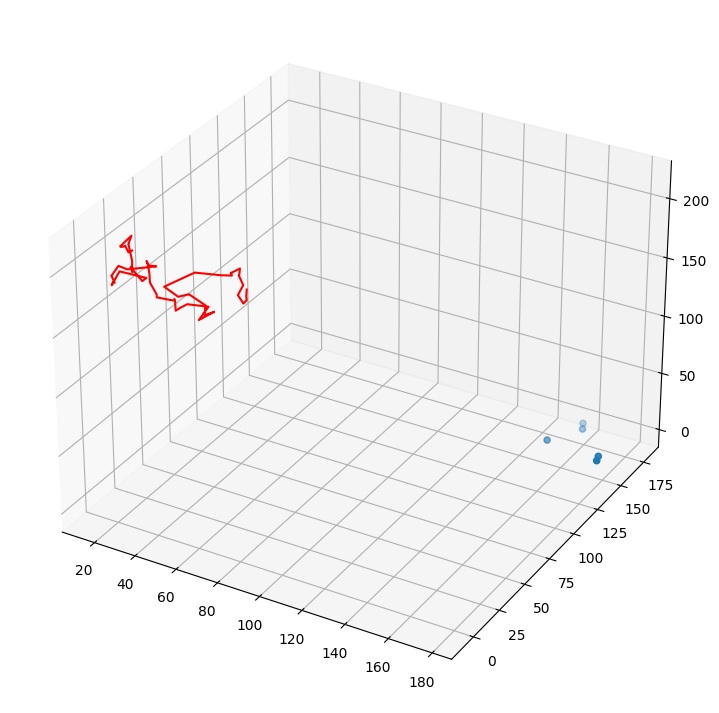

In [26]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

fig =  plt.figure(figsize=[10,9])
ax=fig.add_subplot(1,1,1, projection='3d')

loc = np.array(location)
user = np.array(user)
print(loc.shape)
print(user.shape)
ax.plot(loc[:,0],loc[:,1],loc[:,2],'r')
ax.scatter(user[:,0],user[:,1],user[:,2],'b*')
plt.show()

In [ ]:
model = PN() # model class 정의해주고,
model.load_state_dict(torch.load(save_model_path)) #parameter load

In [ ]:
#environment 바꿔보기
import random as rd
class env_uav():
    def __init__(self):
        self.q = [[20.,20.,200.]]
        self.V = 6
        self.L = 3 
        self.K = 5 
        self.T = 60
        self.N = 60
        self.user = []
        self.done = False
        self.t = self.L 
        self.state = []
  
    def user_set(self):
    #user random location
        for k in range(self.K):
            self.user.append([rd.randint(150,180),rd.randint(150,180),0]) # 5 x 3(x,y,z)
        return self.user

    def cal_rate(self,t): #reward 구할 때
        sum = 0   # time step t에서의 sum rate를 return 즉, 이게 수신 강도이자 reward
        for i in range(self.K):#np.log2
            sum += np.log2(1+1/np.sqrt(np.power(self.q[t][0]-self.user[i][0],2)+np.power(self.q[t][1]-self.user[i][1],2)+np.power(self.q[t][2]-self.user[i][2],2)))
        return sum # 1+를 뺼까
  
    def state_rate(self,t): #state 구할 때
        sum = 0   # time step t에서의 sum rate를 return 즉, 이게 수신 강도이자 reward
        for i in range(self.K):#np.log2
            sum += np.log2(1+1/np.sqrt(np.power(self.q[t][0]-self.user[i][0],2)+np.power(self.q[t][1]-self.user[i][1],2)+np.power(self.q[t][2]-self.user[i][2],2)))
        return sum*1000 # 1+를 뺼까 log를 다시 씌울까


    def q_location(self,a,t): #t+1의 observation  
        #v, seta, low => dtype = tensor
        v , seta , low = a
        v = v.detach().numpy()*self.V; seta = seta.detach().numpy()*180; low = low.detach().numpy()*360

        self.q.append([self.q[t][0] + np.sin(seta*np.pi/180)*np.cos(low*np.pi/180)*v\
                       ,self.q[t][1] + np.sin(low*np.pi/180)*np.sin(seta*np.pi/180)*v,\
                       self.q[t][2] + np.cos(seta*np.pi/180)*v])
  
    def init_state(self):
        s_0 = self.state_rate(0) # q0에서의 e
        state = []
        for i in range(self.L):
            init_action = torch.tensor([torch.rand(1),torch.rand(1),torch.rand(1)],dtype = torch.float)
            self.q_location(init_action,i) # action받고 행동
            s_1 = self.state_rate(i+1)
            delta = (s_1 - s_0) # state가 너무 작아서 
            state.append(delta)
            s_0 = s_1

        return state
    def reset(self): # q, user,done initialize
        self.user = []
        self.q = [[20.,20.,200.]]
        user = self.user_set()
        self.done = False
        return user

    def current_uav(self): # 현재 uav 위치
        return self.q

    def step(self,a,s,t) : #action받으면 reward와 transition, done return 
        #a는 tensor
        _,delta_2,delta_3 = s
        state = []

        s_0 = self.state_rate(t)  #t에서의 rate
        self.q_location(a,t)  # t+1에서의 위치
        s_1 = self.state_rate(t+1) # t+1에서의 rate
        delta_1 = s_1 - s_0
        delta_1 = delta_1 
        delta_2 = delta_2 
        delta_3 = delta_3 

        state.append(delta_2)
        state.append(delta_3)
        state.append(delta_1)

        r = self.cal_rate(t)

        self.t += 1 #실제로 움직인다 -> time step이 증가 => T가 되면 종료
        if self.t >= self.T:
            self.done = True
        return state, r, self.done # list(3,) , numpy, bool

In [ ]:
#user generate, p, done 초기화
env = env_uav()
user = env.reset()
#1 ~ L 까지 random action =======================================
s = env.init_state()
sum_rate =0 

for t in range(3,60):
    action =model(torch.tensor(s).float()) 
    s_prime , reward, _ = env.step(action,s,t)  
    s = s_prime
  
for i in range(60):
    sum_rate += env.cal_rate(i)

location = env.current_uav()
location = np.array(location)


In [ ]:
fig =  plt.figure(figsize=[10,9])
ax=fig.add_subplot(1,1,1, projection='3d')

loc = np.array(location)
user = np.array(user)

ax.plot(loc[:,0],loc[:,1],loc[:,2],'r')
ax.scatter(user[:,0],user[:,1],user[:,2],'b*')
plt.show()